# Customer Segmentation Project

Link dos dados:
https://www.kaggle.com/code/fabiendaniel/customer-segmentation/data

Link do Blog:
https://www.comunidadedatascience.com/como-criar-um-programa-de-fidelidade-para-empresa/

Link de projeto semelhante:
https://github.com/marxcerqueira/Kaggle-HighValue-Custormers-Identification

## 1. Importando as bibliotecas e o conjunto de dados

---


Essa é a etapa inicial em que iremos importar as bibliotecas a serem utilizadas no nosso código e instanciar o nosso conjunto de dados em estudo.

In [ ]:
!pip install  boruta
!pip uninstall umap
!pip install umap-learn

     |████████████████████████████████| 56 kB 3.3 MB/s 
     |████████████████████████████████| 88 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 18.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=3eed39c6f127f1f62d189e0466be5fd45813c89ede27e90b874eccfb57852544
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=c1f6d7d4f686023894ca5964d35c09e26cf3370b874d2f4f2fdcaa791ca97908
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
# importanto as bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import re
from scipy import stats

In [ ]:
df_inicial = pd.read_csv('data.csv', encoding= 'unicode_escape')

In [ ]:
df_inicial.sample(n=5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
39005,539609,22549,PICTURE DOMINOES,1,12/20/2010 14:15,1.45,15527.0,United Kingdom
97774,544657,22939,APRON APPLE DELIGHT,4,2/22/2011 13:08,4.95,14895.0,United Kingdom
270201,560552,22620,4 TRADITIONAL SPINNING TOPS,2,7/19/2011 12:54,1.45,15311.0,United Kingdom
434001,574020,22835,HOT WATER BOTTLE I AM SO POORLY,4,11/2/2011 12:15,4.95,14673.0,United Kingdom
442810,574682,22629,SPACEBOY LUNCH BOX,1,11/6/2011 12:44,1.95,14963.0,United Kingdom


## 2. Verificação da Sanidade dos dados
Antes de tudo, é necessário verificar as inconsistências, valores vazios ou duplicados dos nossos dados e tratá-las a fim de que possam ser úteis em nossas avaliações e modelos

In [ ]:
# tamanho do dataset
print('Number of rows: {}'.format(df_inicial.shape[0]))
print('Number of cols: {}'.format(df_inicial.shape[1]))

Number of rows: 541909
Number of cols: 8


In [ ]:
# tipos de dados
df_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


No nosso conjunto de dados temos as seguintes inforamções:

- Invoice Number: código identificador de cada transação.
- Stock Code Product: código dos itens em estoque.
- Description Product: descrição do item comprado na transação.
- Quantity: A quantidade de cada item comprado por transação.
- Invoice Date: O data e hora em que a transação ocorreu
- Unit Price: Preço do produto por unidade
- Customer ID: identificador único do cliente
- Country: O nome do país que o cliente reside

Sendo assim, é possível perceber algumas as seguintes incosistências nos dados:
- Assim como o "InvoiceNo" e o "StockCode", o tipo da variável "CustomerID" deveria ser classificado como object, pois os números são apenas uma forma de identificar os clientes. Ao passarmos os dados para os modelos, não iremos querer que ele os trate como número.
- É possível perceber que existem dados faltosos (NaNs) que deverão ser substituídos ou deletados.
- É possível aplicar a engenharia de features (feature engineering) em algumas variáveis a fim de extrair informações relevantes.

In [ ]:
df_inicial.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


- Com o método .describe(), é possível notar que os dados numéricos (Quantity e UnitPrice) possuem valores negativos. Geralmente isso indica uma inconsistência nos dados, porém é possível que eles signifiquem outra coisa.

In [ ]:
# verificando o número de linhas duplicadas
df_inicial.duplicated().value_counts()

False    536641
True       5268
dtype: int64

In [ ]:
# Verificando as variáveis de range limitado
df_inicial['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [ ]:
(446/541909)*100

0.08230164105043467

É possível notar que o nome dos países existente em nossos dados são válidos. No entanto, existem cerca de 0,08% dos dados que não tiveram o país especificado ('Unspecified')

In [ ]:
# Verificando a quantidade de clientes
print('Number of clients: {}'.format(df_inicial['CustomerID'].nunique()))

Number of clients: 4372


In [ ]:
# Verificando a quantidade de código de produtos
print('Number of product codes: {}'.format(df_inicial['StockCode'].nunique()))

Number of product codes: 4070


In [ ]:
# Verificando a quantidade de descrição de produtos
print('Number of product description: {}'.format(df_inicial['Description'].nunique()))

Number of product description: 4223


##### Resultado: Com essa verificação da sanidade dos dados, foi notado que algumas correção deverão ser realizadas antes de trabalharmos em cima do nosso conjunto de dados. Dessa maneira, o próximo passo consistirá na correção dessas pendências.

## 3. Limpeza de Dados
Como foi verificado na etapa anterior, existem dados faltosos e duplicados em nosso conjunto de dados que devem ser tratados. Da mesma maneira existem dados que não estão tipificados corretamente. Dessa forma iremos corrigir esse detalhes.

##### Eliminação de Dados Faltosos (NaNs)

In [ ]:
df_inicial.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df_inicial['CustomerID'].isna().sum() /  df_inicial.shape[0] * 100

24.926694334288598

In [ ]:
print('Number of NaNs in CustomerID: {}/{} ({:.2f}%) '.format(df_inicial['CustomerID'].isna().sum(), df_inicial.shape[0], df_inicial['CustomerID'].isna().sum() /  df_inicial.shape[0] * 100))

Number of NaNs in CustomerID: 135080/541909 (24.93%) 


In [ ]:
print('Number of NaNs in Description: {}/{} ({:.2f}%) '.format(df_inicial['Description'].isna().sum(), df_inicial.shape[0], df_inicial['Description'].isna().sum() /  df_inicial.shape[0] * 100))

Number of NaNs in Description: 1454/541909 (0.27%) 


Como os dados faltosos estão nas colunas "Description" e "CustomerID" não temos como substituir os dados faltosos por outros seguindo alguma lógica razoável. Logo, será necessário retirar todas as linhas que tenham algum dado faltoso.

In [ ]:
df_inicial.dropna(inplace=True)
df_inicial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


##### Eliminação dos Dados Duplicados
Ainda existem dados duplicados e os mesmos também não servirão para a nossa análise. Sendo assim, iremos retirá-los

In [ ]:
df_inicial.duplicated().sum()

5225

In [ ]:
df_inicial.drop_duplicates(keep='first', inplace=True)
df_inicial.duplicated().sum()

0

##### Correção do Tipo dos Dados
Vamos agora mudar o tipo da coluna "CustomerID" e assim transformá-la em object, assim como as colunas "InvoiceNo" e "StockCode".

In [ ]:
df_inicial['CustomerID'] = df_inicial['CustomerID'].astype('str')
df_inicial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  object 
 7   Country      401604 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.6+ MB


Passaremos a variável InvoiceDate para o formato DateTime

In [ ]:
pd.to_datetime(df_inicial['InvoiceDate'])
df_inicial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  object 
 7   Country      401604 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.6+ MB


## 4. Explorando as Variáveis
Nessa etapa iremos verificar quais informações estão contidas em nosso conjunto de dados e que tipo de informação podemos criar a partir dele (Feature Engineering)

In [ ]:
df_inicial.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0


Foi notado anteriormente que existem dados negativos nas quantidades, podemos verificar agora por que razão eles existem 

In [ ]:
df_inicial[df_inicial['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


- É possível notar que em todos esses casos, a letra "C" aparece na frente do código de transação ("InvoiceNo"). O que deve indicar que esses itens foram cancelados.
- Outro fator que se destacou é a existência do código de estoque "D" que significa um desconto ("Discount"). Isso sugere que existem códigos específicos para transações que não são apenas a compra de algum item.

Verificando o número de transações de cancelamento e comparando com o total de transações

In [ ]:
# Total de transações
df_inicial['InvoiceNo'].nunique()

22190

In [ ]:
# Criando dataframe com transações canceladas
lista_de_cancelados = []
for i in df_inicial['InvoiceNo']:
  if i[0] == 'C':
    lista_de_cancelados.append(i)
  else:
    pass

df_cancelados = pd.DataFrame(lista_de_cancelados, columns=['Canceled_transactions'])
df_cancelados.head(5)

,Canceled_transactions
0,C536379
1,C536383
2,C536391
3,C536391
4,C536391


In [ ]:
# Total de transações de cancelamento
df_cancelados['Canceled_transactions'].nunique()

3654

In [ ]:
# Percentual de transação canceladas
print('Number canceled transactions: {}/{} ({:.2f}%) '.format(df_cancelados['Canceled_transactions'].nunique(), df_inicial['InvoiceNo'].nunique(), df_cancelados['Canceled_transactions'].nunique() /  df_inicial['InvoiceNo'].nunique() * 100))

Number canceled transactions: 3654/22190 (16.47%) 


A porcetagem de cancelamento de transações é alta (16,47%). Logo, é necessário verificar a origem desses cancelamentos

In [ ]:
# verificando as menores quantidades
df_inicial.sort_values('Quantity', ascending=True).head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,12/2/2010 14:23,0.03,15838.0,United Kingdom
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,4/18/2011 13:08,2.10,15749.0,United Kingdom
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,4/18/2011 13:08,1.85,15749.0,United Kingdom


In [ ]:
# verificando as maiores quantidades
df_inicial.sort_values('Quantity', ascending=False).head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.00,13256.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.21,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.72,13135.0,United Kingdom


- É possível perceber que os nossos dois dados mais extremos do nosso conjunto de dados parecem muito ser um o cancelamento do outro. Isso fica mais evidente ao notar o horário das transições. Logo após a transição de compra ser feita, vemos a transição de cancelamento. 
- No entanto, não parece que essa regra se aplica à todos os cancelamento. Pois vimos existem algumas transações de descontos como essas:

In [ ]:
df_inicial.iloc[141,:]

InvoiceNo             C536379
StockCode                   D
Description          Discount
Quantity                   -1
InvoiceDate    12/1/2010 9:41
UnitPrice                27.5
CustomerID            14527.0
Country        United Kingdom
Name: 141, dtype: object

Dessa maneira, torna-se necessário verificar quais são os cancelamentos que tem uma contrapartida e quais são os cancelamentos que são provenientes de Descontos ou outras possíveis transações.

Os dados de cancelamento tem as seguintes características em comum com o seu dado de transação original:
1. "StockCode" é igual
2. "Description" é igual
3. "Quantity" são opostas (o módulo delas é igual) 
4. "UnitPrice" é igual
5. "InvoiceDate" do cancelamento é maior do que o original
6. O "CustomerID" é o mesmo.
7. "Country" é o mesmo

Sendo assim, é necessário identificar as transações de cancelamento e as suas respectivas contrapartidas

In [ ]:
# Separando as transações de cancelamento e criando a coluna com a Quantidade de itens cancelados

df_limpo = df_inicial.copy(deep = True)
df_limpo['QuantityCanceled'] = 0

transactions_to_remove = [] ; doubtful_transactions = []

for index, col in  df_inicial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_inicial[(df_inicial['CustomerID'] == col['CustomerID']) &
                         (df_inicial['StockCode']  == col['StockCode']) & 
                         (df_inicial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_inicial['Quantity']   > 0)].copy()
    #_________________________________
    # Transações canceladas SEM contrapartidas
    if (df_test.shape[0] == 0): 
        doubtful_transactions.append(index)
    #________________________________
    # Transações canceladas COM contrapartidas
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_limpo.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        transactions_to_remove.append(index)        
    #______________________________________________________________
    # Transações com várias contrapartidas existentes: Foi deletada a primeira ocorrência
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_limpo.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            transactions_to_remove.append(index) 
            break

Neste código acima, todas as transações de cancelamento que tem uma ou mais contrapartidas foram colocadas na lista "entry_to_remove".

Já as transações que não possuem contrapartida foram colocadas na lista "doubtfull_entry".

Além disso, foi criado também uma coluna chamada "QuantityCanceled" que indica a quantidade de item que foram cancelados nas transações originais

In [ ]:
# verificando
print("transactions_to_remove: {}".format(len(transactions_to_remove)))
print("doubtful_transactions: {}".format(len(doubtful_transactions)))

transactions_to_remove: 6151
doubtful_transactions: 2607


In [ ]:
# exemplos de registros com a quantidade de itens cancelados
df_limpo.sort_values('Quantity', ascending=False).head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom,80995
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,74215
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.00,13256.0,United Kingdom,0


Agora iremos retirar todos os dados que possuem transação de cancelamento, juntamente com suas contrapartidas

In [ ]:
df_limpo.drop(labels=transactions_to_remove, axis=0, inplace=True)

Iremos retirar também as transações de cancelamento que não possuem dados de contrapartida

In [ ]:
df_limpo.drop(labels=doubtful_transactions, axis=0, inplace=True)

In [ ]:
df_limpo.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,392846.0,13.144683,181.567121,-720.0,2.00,6.00,12.00,80995.00
UnitPrice,392846.0,3.139243,22.466690,0.0,1.25,1.95,3.75,8142.75
QuantityCanceled,392846.0,0.581826,175.496163,0.0,0.00,0.00,0.00,80995.00


Ainda restam valores negativos. Eles também serão retirados do nosso conjunto de dados

In [ ]:
df_limpo = df_limpo[df_limpo['Quantity'] > 0]

In [ ]:
df_limpo.shape

(392732, 9)

In [ ]:
df_limpo.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,392732.0,13.153718,181.588420,1.0,2.00,6.00,12.00,80995.00
UnitPrice,392732.0,3.125596,22.240725,0.0,1.25,1.95,3.75,8142.75
QuantityCanceled,392732.0,0.581995,175.521632,0.0,0.00,0.00,0.00,80995.00


In [ ]:
df_limpo.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0


##### Checando os valores de "StockCode"
Existem alguns tipos de transações específicas que não se tratam da venda de algum produto como nós pudemos observar com o "D" que significava Desconto.

Dessa forma é necessário checar se existe mais algum tipo de código especial

In [ ]:
list_of_special_codes = df_limpo[df_limpo['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_of_special_codes

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

Agora que sabemos quais são os códigos especiais remanescentes, iremos retirá-los de nosso conjunto de dados

In [ ]:
df_limpo = df_limpo[~df_limpo['StockCode'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

In [ ]:
df_limpo.shape

(391328, 9)

## 5. Feature Engineering
Como conjunto de dados limpo, agora podemos partir para a fase de seleção de features. Nela iremos criar novas variáveis a partir das que já existem, com o objetivo de trazer mais informações interessantes

In [ ]:
df_limpo.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0


##### Date and Time

A data está no formato MM/DD/YYYY. Logo podemos retirar as informações levanto isso em consideração

In [ ]:
# Retirando a informação sobre mês
df_limpo['Month'] = df_limpo['InvoiceDate'].str.split(pat='/', expand=True)[0]
df_limpo['Month']

0         12
1         12
2         12
3         12
4         12
          ..
541904    12
541905    12
541906    12
541907    12
541908    12
Name: Month, Length: 391328, dtype: object

In [ ]:
# Transformando mês para a forma extensa
df_limpo['Month'] = pd.to_datetime(df_limpo['Month'], format='%m').dt.month_name()
df_limpo['Month']

0         December
1         December
2         December
3         December
4         December
            ...   
541904    December
541905    December
541906    December
541907    December
541908    December
Name: Month, Length: 391328, dtype: object

In [ ]:
# Retirando a informação sobre o dia
df_limpo['Day'] = df_limpo['InvoiceDate'].str.split(pat='/', expand=True)[1]
df_limpo['Day']

0         1
1         1
2         1
3         1
4         1
         ..
541904    9
541905    9
541906    9
541907    9
541908    9
Name: Day, Length: 391328, dtype: object

In [ ]:
# Retirando a informação sobre Ano e Horário
df_limpo['Year_and_time'] = df_limpo['InvoiceDate'].str.split(pat='/', expand=True)[2]
df_limpo['Year_and_time'] 

0          2010 8:26
1          2010 8:26
2          2010 8:26
3          2010 8:26
4          2010 8:26
             ...    
541904    2011 12:50
541905    2011 12:50
541906    2011 12:50
541907    2011 12:50
541908    2011 12:50
Name: Year_and_time, Length: 391328, dtype: object

In [ ]:
# Separando a informação de Ano em uma nova coluna
df_limpo['Year'] = df_limpo['Year_and_time'].str.split(pat=' ', expand=True)[0]
df_limpo['Year']

0         2010
1         2010
2         2010
3         2010
4         2010
          ... 
541904    2011
541905    2011
541906    2011
541907    2011
541908    2011
Name: Year, Length: 391328, dtype: object

In [ ]:
# Separando a informação de Horário em uma nova coluna
df_limpo['Time'] = df_limpo['Year_and_time'].str.split(pat=' ', expand=True)[1]
df_limpo['Time']

0          8:26
1          8:26
2          8:26
3          8:26
4          8:26
          ...  
541904    12:50
541905    12:50
541906    12:50
541907    12:50
541908    12:50
Name: Time, Length: 391328, dtype: object

In [ ]:
# Transformando o tipo da variável para DateTime
df_limpo['Time'] = pd.to_datetime(df_limpo['Time'], format='%H:%M').dt.time

In [ ]:
# verificando o range dos horários
print('Horário de venda mais cedo: {}'.format(df_limpo['Time'].min()))
print('Horário de venda mais tarde: {}'.format(df_limpo['Time'].max()))

Horário de venda mais cedo: 06:20:00
Horário de venda mais tarde: 20:18:00


É possível perceber que as vendas ocorrem entre as 06:00h e as 20:30h, não existindo registros fora desse período. Por esse motivo, iremos criar também a variável "Period" que indicará a seguinte informação:
- 'morning': horário de transação realizados entre 06:00 e 11:59
- 'afternoon': horário de transação realizados entre 12:00 e 17:59
- 'night': horário de transação realizado entre 18:00 e 20:30

In [ ]:
df_limpo['Hour'] = df_limpo['Time'].astype(str)
df_limpo['Hour']

0         08:26:00
1         08:26:00
2         08:26:00
3         08:26:00
4         08:26:00
            ...   
541904    12:50:00
541905    12:50:00
541906    12:50:00
541907    12:50:00
541908    12:50:00
Name: Hour, Length: 391328, dtype: object

In [ ]:
df_limpo['Hour'] = df_limpo['Hour'].str.split(pat=':', expand=True)[0]
df_limpo['Hour']

0         08
1         08
2         08
3         08
4         08
          ..
541904    12
541905    12
541906    12
541907    12
541908    12
Name: Hour, Length: 391328, dtype: object

In [ ]:
df_limpo.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Month,Day,Year_and_time,Year,Time,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,08
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,08
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,08
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,08
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,08


In [ ]:
periods = {'06': 'morning', '07': 'morning', '08': 'morning', '09': 'morning', '10': 'morning', '11': 'morning',
           '12': 'afternoon', '13': 'afternoon', '14': 'afternoon', '15': 'afternoon', '16': 'afternoon', '17': 'afternoon',
           '18': 'night', '19': 'night', '20': 'night'}
df_limpo['Hour'] = df_limpo['Hour'].map(periods)
df_limpo['Hour']

0           morning
1           morning
2           morning
3           morning
4           morning
            ...    
541904    afternoon
541905    afternoon
541906    afternoon
541907    afternoon
541908    afternoon
Name: Hour, Length: 391328, dtype: object

In [ ]:
hour_to_period = {'Hour': 'Period'}
df_limpo = df_limpo.rename(columns=hour_to_period)

In [ ]:
df_limpo['InvoiceDate'] = pd.to_datetime(df_limpo['InvoiceDate'])

In [ ]:
# Verificando o dataset com as novas colunas
df_limpo.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Month,Day,Year_and_time,Year,Time,Period
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning


##### Total Revenue

Uma última informação muito importante que pode ser extraída dos nossos dados é o valor total de cada transação. Para isso iremos multiplicar a quantidade pelo preço unitário.

In [ ]:
df_limpo['Total_Revenue'] = (df_limpo['Quantity'] - df_limpo['QuantityCanceled']) * df_limpo['UnitPrice']
df_limpo.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Month,Day,Year_and_time,Year,Time,Period,Total_Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,December,1,2010 8:26,2010,08:26:00,morning,20.34


Agora que já terminamos de retirar as informações interessantes da coluna "InvoiceDate", podemos excluir as colunas com informações que não serão utilizadas. A saber, as colunas "InvoiceDate" e "Year_and_time"

In [ ]:
# Retirando as colunas desnecessárias
df_limpo.drop(columns=['Year_and_time'], axis=1, inplace=True)
df_limpo.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Month,Day,Year,Time,Period,Total_Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,December,1,2010,08:26:00,morning,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,December,1,2010,08:26:00,morning,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,December,1,2010,08:26:00,morning,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,December,1,2010,08:26:00,morning,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,December,1,2010,08:26:00,morning,20.34


Podemos também retirar as linhas cuja receita foi igual a zero, pois não serão utilizadas em nossas avaliações

In [ ]:
df_pronto = df_limpo[df_limpo['Total_Revenue'] > 0]

Outra possibilidade é criarmos uma feature com a quantidade total e excluir as linhas que não tiverem quantidade nenhuma

In [ ]:
df_pronto['Total_Quantity'] = df_pronto['Quantity'] - df_pronto['QuantityCanceled']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_pronto.shape

(389332, 16)

In [ ]:
df_pronto = df_pronto[df_pronto['Total_Quantity'] > 0]
df_pronto.shape

(389332, 16)

In [ ]:
# retirando as colunas de quantidades e quantidades canceladas
df_pronto.drop(columns=['Quantity', 'QuantityCanceled'], axis=1, inplace=True)
df_pronto.head()

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Period,Total_Revenue,Total_Quantity
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,December,1,2010,08:26:00,morning,15.30,6
1,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,1,2010,08:26:00,morning,20.34,6
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,December,1,2010,08:26:00,morning,22.00,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,1,2010,08:26:00,morning,20.34,6
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,1,2010,08:26:00,morning,20.34,6


In [ ]:
df_pronto.describe().T

,count,mean,std,min,25%,50%,75%,max
UnitPrice,389332.0,2.874488,4.112542,0.001,1.25,1.95,3.75,649.50
Total_Revenue,389332.0,21.339631,68.256355,0.001,4.95,11.90,19.80,7144.72
Total_Quantity,389332.0,12.624526,42.063618,1.000,2.00,6.00,12.00,4704.00


In [ ]:
df_pronto.shape

(389332, 14)

 ## 6. Análise Exploratória dos Dados (EDA)
Agora nós estamos com o nosso dataset limpo e com novas features, estamos prontos para iniciarmos o nosso próximo passo. A Análise Exploratória de Dados (EDA). Nela vamos ver como os dados estão se comportando e iremos testar algumas hipósteses de negócio

#### Distribuição dos dados numéricos

Primeiramente, irei verificar que tipo de informação podemos estrair das nossas variáveis numéricas. A saber são:
- "UnitPrice"
- "Total_Revenue"
- "Total_Quantity"

In [ ]:
# separando dados categóricos dos numéricos
df_numericos = df_pronto.select_dtypes( include=np.number)
df_categoricos = df_pronto.select_dtypes( exclude=np.number)

In [ ]:
# verificando as medidas de tendências central
central_1 = pd.DataFrame(df_numericos.apply(np.mean)).T
central_2 = pd.DataFrame(df_numericos.apply(np.median)).T
central_3 = pd.DataFrame(df_numericos.mad()).T

list_trimmed_mean_05 = []
for col in df_numericos:
  trimmed_mean_05 = stats.trim_mean(df_numericos[col], 0.05)
  list_trimmed_mean_05.append(trimmed_mean_05)

central_4 = pd.DataFrame(list_trimmed_mean_05)
central_4 = central_4.T
central_4.columns = df_numericos.columns
central_3 = pd.DataFrame(df_numericos.mad()).T

In [ ]:
# definindo função para cálculo de distância interquartil
def find_iqr(x):
  return np.subtract(*np.percentile(x, [75, 25]))

In [ ]:
# Calculando medidas de dispersão
dispersao_1 = pd.DataFrame(df_numericos.apply(np.min)).T
dispersao_2 = pd.DataFrame(df_numericos.apply(np.max)).T
dispersao_3 = pd.DataFrame(df_numericos.apply(np.std)).T
dispersao_4 = pd.DataFrame(df_numericos.apply(lambda x: x.max()-x.min())).T
dispersao_5 = pd.DataFrame(df_numericos.apply(find_iqr)).T
dispersao_6 = pd.DataFrame(df_numericos.apply(lambda x: x.skew())).T
dispersao_7 = pd.DataFrame(df_numericos.apply(lambda x: x.kurtosis())).T

In [ ]:
# Concatenando todas as informações
metricas_numericos = pd.concat([dispersao_1, dispersao_2, dispersao_4, dispersao_5, central_1, central_4, central_2, central_3, dispersao_3, dispersao_6, dispersao_7]).T.reset_index()
metricas_numericos.columns = ['attributes', 'min', 'max', 'range', 'IQR_range', 'mean','trimmed_mean_(5%)', 'median','MAD', 'std', 'skew', 'kurtosis']
round(metricas_numericos,3)

,attributes,min,max,range,IQR_range,mean,trimmed_mean_(5%),median,MAD,std,skew,kurtosis
0,UnitPrice,0.001,649.50,649.499,2.50,2.874,2.457,1.95,2.042,4.113,27.857,2353.495
1,Total_Revenue,0.001,7144.72,7144.719,14.85,21.340,13.897,11.90,19.097,68.256,28.435,1448.921
2,Total_Quantity,1.000,4704.00,4703.000,10.00,12.625,7.874,6.00,12.348,42.064,29.930,1783.846


É possível notar que os nossos dados são muito influenciados pelos outliers. A diferença entre a medidas de dispersão e tendência central comuns para as medidas de dispersão e tendência central robustas são muito grandes. Isso fica evidente nos seguintes exemplos:
- "Total_Revenue" range = 7144,719 & "Total_Revenue" Interquartile range = 14.85
- "Total_Quantity" mean = 12.625 & "Total_Quantity" trimmed mean (5%) = 7.874

Podemos também notar esse fenômeno com alguns gráficos de apoio

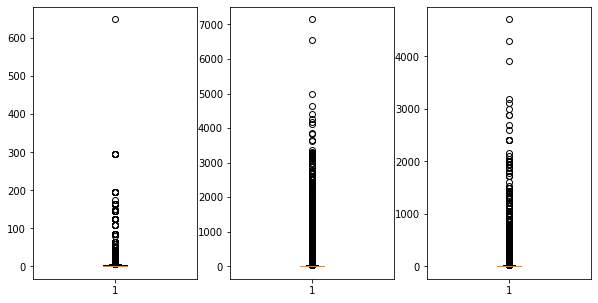

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))

ax[0].boxplot(df_pronto['UnitPrice'])
ax[1].boxplot(df_pronto['Total_Revenue'])
ax[2].boxplot(df_pronto['Total_Quantity']);

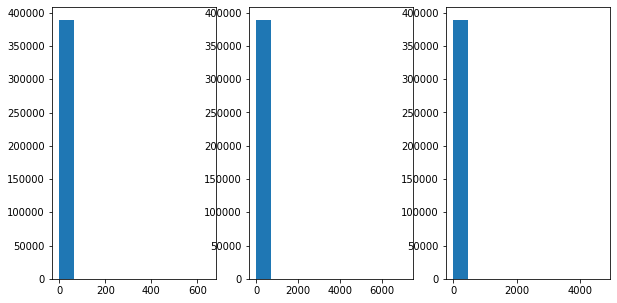

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))

ax[0].hist(df_pronto['UnitPrice'])
ax[1].hist(df_pronto['Total_Revenue'])
ax[2].hist(df_pronto['Total_Quantity']);

#### Análise dos dados categóricos

Após analisar os dados numéricos, podemos analisar os dados categóriocos e verificar que tipo de informação eles podem nos oferecer

In [ ]:
df_categoricos.head()

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,Month,Day,Year,Time,Period
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,17850.0,United Kingdom,December,1,2010,08:26:00,morning
1,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,17850.0,United Kingdom,December,1,2010,08:26:00,morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,17850.0,United Kingdom,December,1,2010,08:26:00,morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,17850.0,United Kingdom,December,1,2010,08:26:00,morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,17850.0,United Kingdom,December,1,2010,08:26:00,morning


In [ ]:
# Criando dados de moda e contando número de dados únicos
categoric_1 = pd.DataFrame(df_categoricos.nunique()).T
categoric_2 = pd.DataFrame(df_categoricos.mode())

In [ ]:
# Verificando as quantidades de valores único e a moda de cada atributo
metricas_categoricos = pd.concat([categoric_1, categoric_2]).T
metricas_categoricos.columns = ['nunique', 'mode']
metricas_categoricos

,nunique,mode
InvoiceNo,18332,576339
StockCode,3656,85123A
Description,3866,WHITE HANGING HEART T-LIGHT HOLDER
InvoiceDate,17106,2011-11-14 15:27:00
CustomerID,4330,17841.0
Country,37,United Kingdom
Month,12,November
Day,31,6
Year,2,2011
Time,738,13:35:00


 De todas as 18332 transações realizadas, temos o registro de mais de 4330 clientes realizados em 37 países, sendo o Reino Unido o país com a maior frequencia de registros

Quais são os clientes que geram um maior valor arrecadado

In [ ]:
df_pronto.head()

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Period,Total_Revenue,Total_Quantity
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,December,1,2010,08:26:00,morning,15.30,6
1,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,1,2010,08:26:00,morning,20.34,6
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,December,1,2010,08:26:00,morning,22.00,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,1,2010,08:26:00,morning,20.34,6
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,1,2010,08:26:00,morning,20.34,6


In [ ]:
# Lucro Total por país
df_pronto.groupby('Country').sum().sort_values(by='Total_Revenue', ascending=False)

,UnitPrice,Total_Revenue,Total_Quantity
Country,,,
United Kingdom,990400.231,6832796.001,4018206
Netherlands,5681.930,283443.540,199934
EIRE,28469.340,253841.620,136758
Germany,23279.280,202541.080,116773
France,21247.090,182253.060,109514
Australia,3131.790,137128.860,83468
Switzerland,5169.730,51907.200,29692
Spain,7599.060,51873.900,26637
Belgium,5838.500,36726.340,22894


In [ ]:
df_pivot_test1 = pd.pivot_table(data=df_pronto, index=['InvoiceNo','CustomerID','Country'], aggfunc={'Total_Revenue': np.sum, 'Total_Quantity': np.sum}).sort_values(by='Total_Revenue', ascending=False)
df_pivot_test1

,,,Total_Quantity,Total_Revenue
InvoiceNo,CustomerID,Country,,
567423,17450.0,United Kingdom,12386,30757.00
556917,12415.0,Australia,15049,22775.93
572209,18102.0,United Kingdom,1920,22206.00
567381,17450.0,United Kingdom,6760,22104.80
563614,12415.0,Australia,12196,21880.44
...,...,...,...,...
539645,17230.0,United Kingdom,1,0.95
540945,16554.0,United Kingdom,1,0.85
542736,14744.0,United Kingdom,1,0.55


In [ ]:
df_pivot_test1['index1'] = df_pivot_test1.index.to_numpy()

In [ ]:
df_pivot_test2 = pd.pivot_table(data=df_pronto, index=['InvoiceNo'], aggfunc={'Total_Revenue': np.sum, 'Total_Quantity': np.sum}).sort_values(by='Total_Revenue', ascending=False)
df_pivot_test2

,Total_Quantity,Total_Revenue
InvoiceNo,,
567423,12386,30757.00
556917,15049,22775.93
572209,1920,22206.00
567381,6760,22104.80
563614,12196,21880.44
...,...,...
539645,1,0.95
540945,1,0.85
542736,1,0.55


In [ ]:
df_pivot_test1 = pd.DataFrame(df_pivot_test1['index1'].to_list(), index=df_pivot_test1.index)
df_pivot_test1

,,,0,1,2
InvoiceNo,CustomerID,Country,,,
567423,17450.0,United Kingdom,567423,17450.0,United Kingdom
556917,12415.0,Australia,556917,12415.0,Australia
572209,18102.0,United Kingdom,572209,18102.0,United Kingdom
567381,17450.0,United Kingdom,567381,17450.0,United Kingdom
563614,12415.0,Australia,563614,12415.0,Australia
...,...,...,...,...,...
539645,17230.0,United Kingdom,539645,17230.0,United Kingdom
540945,16554.0,United Kingdom,540945,16554.0,United Kingdom
542736,14744.0,United Kingdom,542736,14744.0,United Kingdom


In [ ]:
df_pivot_test3 = df_pivot_test1[[0,1,2]]
df_pivot_test3.rename(columns={0: 'InvoiceID', 1: 'CustomerID', 2: 'Country'}, inplace=True)
df_pivot_test3

,,,InvoiceID,CustomerID,Country
InvoiceNo,CustomerID,Country,,,
567423,17450.0,United Kingdom,567423,17450.0,United Kingdom
556917,12415.0,Australia,556917,12415.0,Australia
572209,18102.0,United Kingdom,572209,18102.0,United Kingdom
567381,17450.0,United Kingdom,567381,17450.0,United Kingdom
563614,12415.0,Australia,563614,12415.0,Australia
...,...,...,...,...,...
539645,17230.0,United Kingdom,539645,17230.0,United Kingdom
540945,16554.0,United Kingdom,540945,16554.0,United Kingdom
542736,14744.0,United Kingdom,542736,14744.0,United Kingdom


In [ ]:
df_pivot_test4 = pd.merge(df_pivot_test2, df_pivot_test3, how='left', on='InvoiceNo')
df_pivot_test4

,Total_Quantity,Total_Revenue,InvoiceID,CustomerID,Country
InvoiceNo,,,,,
567423,12386,30757.00,567423,17450.0,United Kingdom
556917,15049,22775.93,556917,12415.0,Australia
572209,1920,22206.00,572209,18102.0,United Kingdom
567381,6760,22104.80,567381,17450.0,United Kingdom
563614,12196,21880.44,563614,12415.0,Australia
...,...,...,...,...,...
539645,1,0.95,539645,17230.0,United Kingdom
540945,1,0.85,540945,16554.0,United Kingdom
542736,1,0.55,542736,14744.0,United Kingdom


In [ ]:
df_pivot_test4.drop(columns='InvoiceID', inplace=True)
df_pivot_test4

,Total_Quantity,Total_Revenue,CustomerID,Country
InvoiceNo,,,,
567423,12386,30757.00,17450.0,United Kingdom
556917,15049,22775.93,12415.0,Australia
572209,1920,22206.00,18102.0,United Kingdom
567381,6760,22104.80,17450.0,United Kingdom
563614,12196,21880.44,12415.0,Australia
...,...,...,...,...
539645,1,0.95,17230.0,United Kingdom
540945,1,0.85,16554.0,United Kingdom
542736,1,0.55,14744.0,United Kingdom


In [ ]:
df_pivoted = df_pivot_test4

Com o dataset "df_pivoted" nós temos as informações concentradas por código de transação "InvoiceNo". Dessa maneira, fica fácil visualizar as informações por transação.

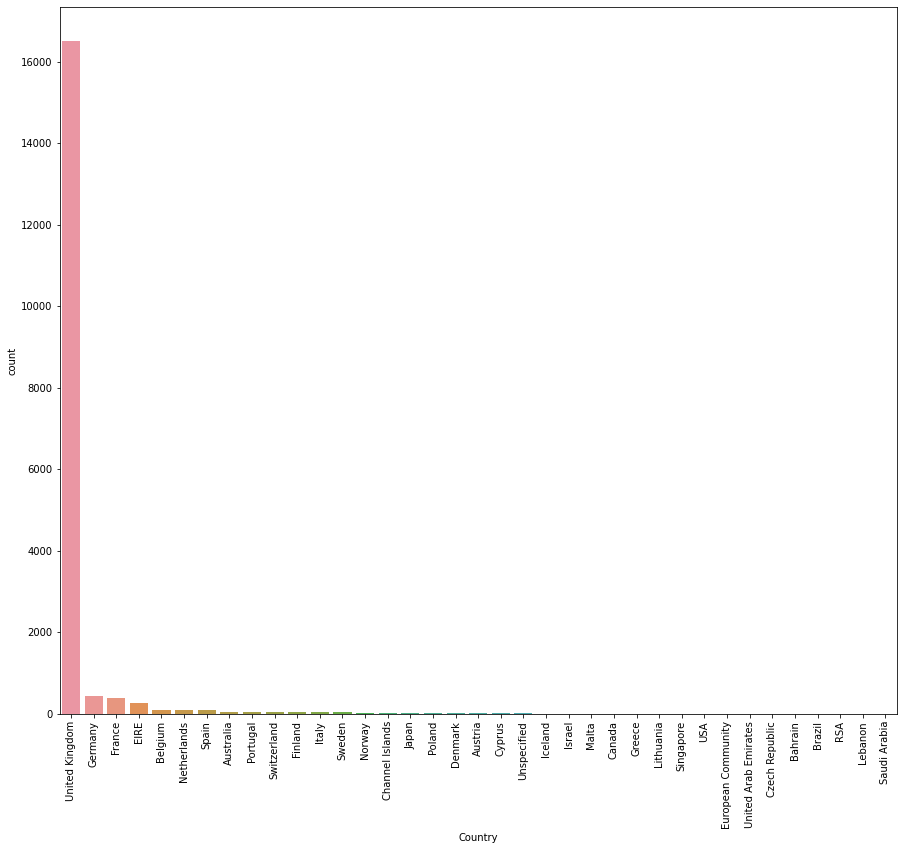

In [ ]:
# grafico de transações por país
plt.figure(figsize=(15,13))
sns.countplot(data=df_pivoted, x='Country', order=df_pivoted['Country'].value_counts().index)
plt.xticks(rotation=90, fontsize=10)

plt.show()

In [ ]:
# qual é a porcentagem de receita gerada pelos clientes que mais usam realizam transações?

In [ ]:
df_pivoted

,Total_Quantity,Total_Revenue,CustomerID,Country
InvoiceNo,,,,
567423,12386,30757.00,17450.0,United Kingdom
556917,15049,22775.93,12415.0,Australia
572209,1920,22206.00,18102.0,United Kingdom
567381,6760,22104.80,17450.0,United Kingdom
563614,12196,21880.44,12415.0,Australia
...,...,...,...,...
539645,1,0.95,17230.0,United Kingdom
540945,1,0.85,16554.0,United Kingdom
542736,1,0.55,14744.0,United Kingdom


In [ ]:
df_percentile_test = df_pivoted.groupby('CustomerID').sum().sort_values(by='Total_Revenue', ascending=False)
df_percentile_test.reset_index(inplace=True)

In [ ]:
df_percentile_test.reset_index(inplace=True)
df_percentile_test

,index,CustomerID,Total_Quantity,Total_Revenue
0,0,14646.0,196556,278742.02
1,1,18102.0,64124,259657.30
2,2,17450.0,69777,193417.63
3,3,14911.0,77681,135134.71
4,4,12415.0,77066,123816.79
...,...,...,...,...
4325,4325,17956.0,1,12.75
4326,4326,14792.0,2,6.20
4327,4327,16454.0,2,5.90
4328,4328,16738.0,3,3.75


In [ ]:
df_percentile_divided = df_percentile_test.groupby(pd.cut(df_percentile_test.index, np.percentile(df_percentile_test.index, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]), include_lowest=True)).sum()
df_percentile_divided

,index,Total_Quantity,Total_Revenue
"(-0.001, 432.9]",93528,2865769,4989865.230
"(432.9, 865.8]",281017,694536,1133246.170
"(865.8, 1298.7]",468506,430165,702430.370
"(1298.7, 1731.6]",655995,292296,473362.640
"(1731.6, 2164.5]",843484,203394,333189.050
"(2164.5, 2597.4]",1030973,153248,244660.961
"(2597.4, 3030.3]",1218462,108041,173873.930
"(3030.3, 3463.2]",1405951,82848,128536.280
"(3463.2, 3896.1]",1593440,55413,84409.970
"(3896.1, 4329.0]",1780929,29422,44626.650


In [ ]:
lista_de_porcentagens = ['1st_quantile','2nd_quantile', '3dr_quantile', '4th_quantile', '5th_quantile', '6th_quantile', '7th_quantile', '8th_quantile', '9th_quantile', '10th_quantile']
df_percentile_divided['index'] = lista_de_porcentagens
df_percentile_divided

,index,Total_Quantity,Total_Revenue
"(-0.001, 432.9]",1st_quantile,2865769,4989865.230
"(432.9, 865.8]",2nd_quantile,694536,1133246.170
"(865.8, 1298.7]",3dr_quantile,430165,702430.370
"(1298.7, 1731.6]",4th_quantile,292296,473362.640
"(1731.6, 2164.5]",5th_quantile,203394,333189.050
"(2164.5, 2597.4]",6th_quantile,153248,244660.961
"(2597.4, 3030.3]",7th_quantile,108041,173873.930
"(3030.3, 3463.2]",8th_quantile,82848,128536.280
"(3463.2, 3896.1]",9th_quantile,55413,84409.970
"(3896.1, 4329.0]",10th_quantile,29422,44626.650


In [ ]:
df_divided = df_percentile_divided.set_index('index',drop=True)
df_divided

,Total_Quantity,Total_Revenue
index,,
1st_quantile,2865769,4989865.230
2nd_quantile,694536,1133246.170
3dr_quantile,430165,702430.370
4th_quantile,292296,473362.640
5th_quantile,203394,333189.050
6th_quantile,153248,244660.961
7th_quantile,108041,173873.930
8th_quantile,82848,128536.280
9th_quantile,55413,84409.970


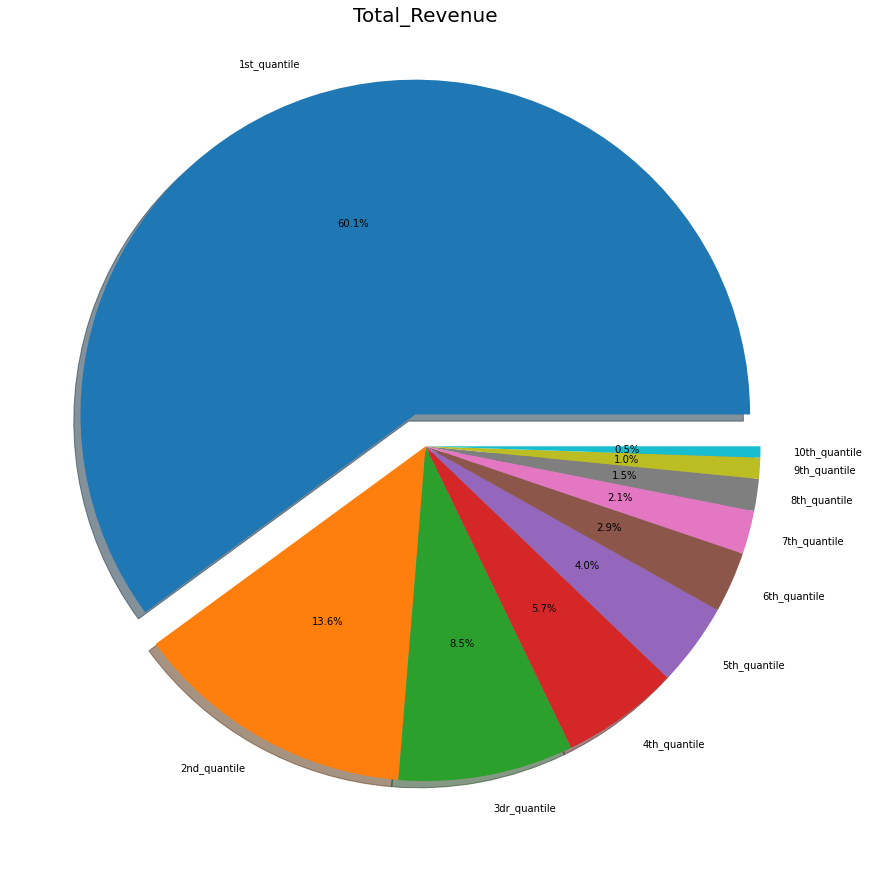

In [ ]:
explode = [0.1,0,0,0,0,0,0,0,0,0]

plt.figure(figsize=(15,20))
plt.pie(df_divided['Total_Revenue'], labels=df_divided.index, explode=explode, autopct='%1.1f%%', shadow=True)
plt.title('Total_Revenue',fontsize=20)
plt.show()

Apenas 10% dos clientes geram mais de 60% do total de receitas arrecadadas em nossas lojas.

A grande pergunta é: Como identificar esses clientes?
O que esses clientes possuem em comum?
Que tipo de ação pode ser realizada para que esses clientes continuem comprando?

In [ ]:
df_pronto['CustomerID'].nunique()

4330

Ou seja, de 4330 clientes, 433 são responsáveis por mais de 60% de toda a receita de nossa loja. Dessa maneira, como podemos identificar quem são esses clientes? O que eles têm em comum? Que ações a equipe de marketing pode fazer para trazer mais clientes desse tipo?

#### Análise dos Clientes

In [ ]:
df_pronto.head()

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Period,Total_Revenue,Total_Quantity
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,December,1,2010,08:26:00,morning,15.30,6
1,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,1,2010,08:26:00,morning,20.34,6
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,December,1,2010,08:26:00,morning,22.00,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,1,2010,08:26:00,morning,20.34,6
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,1,2010,08:26:00,morning,20.34,6


In [ ]:
df_clientes_ref = df_pronto.drop(['InvoiceNo', 'StockCode', 'Description',
                   'InvoiceDate', 'UnitPrice', 'Country', 'Month',
                   'Day', 'Year', 'Time', 'Period', 'Total_Revenue', 'Total_Quantity'], axis = 1).drop_duplicates(ignore_index = True).copy()

df_clientes_ref

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0
...,...
4325,13436.0
4326,15520.0
4327,13298.0
4328,14569.0


##### Receita Total de cada cliente

In [ ]:
df_pronto.groupby(['CustomerID','Total_Revenue']).sum()

UnitPrice  Total_Quantity
CustomerID Total_Revenue                           
12347.0    5.04                0.42              12
           6.00                0.25              24
           7.80                1.30              24
           8.40                1.68              80
           8.50                3.40              40
...                             ...             ...
18287.0    53.10               2.95              18
           59.40               1.65              36
           69.60               4.35             144
           81.12               3.38              96
           87.00               1.45              60

[142689 rows x 2 columns]

In [ ]:
df_total_revenues = df_pronto.loc[:, ['CustomerID', 'Total_Revenue']].groupby('CustomerID').sum().reset_index()
df_total_revenues

,CustomerID,Total_Revenue
0,12347.0,4310.00
1,12348.0,1437.24
2,12349.0,1457.55
3,12350.0,294.40
4,12352.0,1265.41
...,...,...
4325,18280.0,180.60
4326,18281.0,80.82
4327,18282.0,176.60
4328,18283.0,2039.58


In [ ]:
df_clientes_ref = pd.merge( df_clientes_ref, df_total_revenues, on='CustomerID', how='left' )
df_clientes_ref

,CustomerID,Total_Revenue
0,17850.0,5322.84
1,13047.0,3105.70
2,12583.0,6690.18
3,13748.0,948.25
4,15100.0,843.15
...,...,...
4325,13436.0,196.89
4326,15520.0,343.50
4327,13298.0,360.00
4328,14569.0,227.39


##### Quantidade de transações por cliente

In [ ]:
df_transacoes = df_pronto[['CustomerID', 'InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns={'InvoiceNo': 'Total_Transactions'})
df_transacoes

,CustomerID,Total_Transactions
0,12347.0,7
1,12348.0,4
2,12349.0,1
3,12350.0,1
4,12352.0,6
...,...,...
4325,18280.0,1
4326,18281.0,1
4327,18282.0,2
4328,18283.0,16


In [ ]:
df_clientes_ref = pd.merge( df_clientes_ref, df_transacoes, on='CustomerID', how='left' )
df_clientes_ref

,CustomerID,Total_Revenue,Total_Transactions
0,17850.0,5322.84,34
1,13047.0,3105.70,9
2,12583.0,6690.18,15
3,13748.0,948.25,5
4,15100.0,843.15,3
...,...,...,...
4325,13436.0,196.89,1
4326,15520.0,343.50,1
4327,13298.0,360.00,1
4328,14569.0,227.39,1


##### Quantidade total de itens comprada por cliente

In [ ]:
df_total_quantity = df_pronto[['CustomerID','Total_Quantity']].groupby('CustomerID').sum().reset_index()
df_total_quantity

,CustomerID,Total_Quantity
0,12347.0,2458
1,12348.0,2332
2,12349.0,630
3,12350.0,196
4,12352.0,463
...,...,...
4325,18280.0,45
4326,18281.0,54
4327,18282.0,98
4328,18283.0,1355


In [ ]:
df_clientes_ref = pd.merge( df_clientes_ref, df_total_quantity, on='CustomerID', how='left' )
df_clientes_ref

,CustomerID,Total_Revenue,Total_Transactions,Total_Quantity
0,17850.0,5322.84,34,1703
1,13047.0,3105.70,9,1361
2,12583.0,6690.18,15,5014
3,13748.0,948.25,5,439
4,15100.0,843.15,3,77
...,...,...,...,...
4325,13436.0,196.89,1,76
4326,15520.0,343.50,1,314
4327,13298.0,360.00,1,96
4328,14569.0,227.39,1,79


##### Quantidade total de produtos comprados por cliente

In [ ]:
df_produtos = df_pronto[['CustomerID','StockCode']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns={'StockCode': 'Total_Products'})
df_produtos

,CustomerID,Total_Products
0,12347.0,103
1,12348.0,21
2,12349.0,72
3,12350.0,16
4,12352.0,57
...,...,...
4325,18280.0,10
4326,18281.0,7
4327,18282.0,12
4328,18283.0,262


In [ ]:
df_clientes_ref = pd.merge( df_clientes_ref, df_produtos, on='CustomerID', how='left' )
df_clientes_ref

,CustomerID,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products
0,17850.0,5322.84,34,1703,21
1,13047.0,3105.70,9,1361,105
2,12583.0,6690.18,15,5014,114
3,13748.0,948.25,5,439,24
4,15100.0,843.15,3,77,1
...,...,...,...,...,...
4325,13436.0,196.89,1,76,12
4326,15520.0,343.50,1,314,18
4327,13298.0,360.00,1,96,2
4328,14569.0,227.39,1,79,10


##### Dias da última compra efetuada (Recência)

In [ ]:
df_recencia = df_pronto[['CustomerID','InvoiceDate']].groupby('CustomerID').max().reset_index()
df_recencia

,CustomerID,InvoiceDate
0,12347.0,2011-12-07 15:52:00
1,12348.0,2011-09-25 13:13:00
2,12349.0,2011-11-21 09:51:00
3,12350.0,2011-02-02 16:01:00
4,12352.0,2011-11-03 14:37:00
...,...,...
4325,18280.0,2011-03-07 09:52:00
4326,18281.0,2011-06-12 10:53:00
4327,18282.0,2011-12-02 11:43:00
4328,18283.0,2011-12-06 12:02:00


In [ ]:
df_recencia['Rencency_in_days'] = ( df_pronto['InvoiceDate'].max() - df_recencia['InvoiceDate'] ).dt.days
df_recencia = df_recencia[['CustomerID', 'Rencency_in_days']].copy()

In [ ]:
df_recencia = df_recencia.rename(columns={'Rencency_in_days': 'Recency_in_days'})
df_recencia

,CustomerID,Recency_in_days
0,12347.0,1
1,12348.0,74
2,12349.0,18
3,12350.0,309
4,12352.0,35
...,...,...
4325,18280.0,277
4326,18281.0,180
4327,18282.0,7
4328,18283.0,3


In [ ]:
df_clientes_ref = pd.merge( df_clientes_ref, df_recencia, on='CustomerID', how='left' )
df_clientes_ref

,CustomerID,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days
0,17850.0,5322.84,34,1703,21,371
1,13047.0,3105.70,9,1361,105,56
2,12583.0,6690.18,15,5014,114,2
3,13748.0,948.25,5,439,24,95
4,15100.0,843.15,3,77,1,333
...,...,...,...,...,...,...
4325,13436.0,196.89,1,76,12,1
4326,15520.0,343.50,1,314,18,1
4327,13298.0,360.00,1,96,2,0
4328,14569.0,227.39,1,79,10,0


##### Média da Quantidade de itens por transação

In [ ]:
df_aux = ( df_pronto[['CustomerID', 'InvoiceNo', 'Total_Quantity']].groupby( 'CustomerID' ).agg( n_purchase=( 'InvoiceNo', 'nunique'),n_products=( 'Total_Quantity', 'sum' ) ).reset_index() )
df_aux

,CustomerID,n_purchase,n_products
0,12347.0,7,2458
1,12348.0,4,2332
2,12349.0,1,630
3,12350.0,1,196
4,12352.0,6,463
...,...,...,...
4325,18280.0,1,45
4326,18281.0,1,54
4327,18282.0,2,98
4328,18283.0,16,1355


In [ ]:
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']
df_aux

,CustomerID,n_purchase,n_products,avg_basket_size
0,12347.0,7,2458,351.142857
1,12348.0,4,2332,583.000000
2,12349.0,1,630,630.000000
3,12350.0,1,196,196.000000
4,12352.0,6,463,77.166667
...,...,...,...,...
4325,18280.0,1,45,45.000000
4326,18281.0,1,54,54.000000
4327,18282.0,2,98,49.000000
4328,18283.0,16,1355,84.687500


In [ ]:
df_clientes_ref = pd.merge( df_clientes_ref, df_aux[['CustomerID', 'avg_basket_size']], how='left', on='CustomerID' )
df_clientes_ref

,CustomerID,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,avg_basket_size
0,17850.0,5322.84,34,1703,21,371,50.088235
1,13047.0,3105.70,9,1361,105,56,151.222222
2,12583.0,6690.18,15,5014,114,2,334.266667
3,13748.0,948.25,5,439,24,95,87.800000
4,15100.0,843.15,3,77,1,333,25.666667
...,...,...,...,...,...,...,...
4325,13436.0,196.89,1,76,12,1,76.000000
4326,15520.0,343.50,1,314,18,1,314.000000
4327,13298.0,360.00,1,96,2,0,96.000000
4328,14569.0,227.39,1,79,10,0,79.000000


Média da Quantidade de produtos diferentes por transação

In [ ]:
df_aux = ( df_pronto[['CustomerID', 'InvoiceNo', 'StockCode']].groupby( 'CustomerID' ).agg( n_purchase=( 'InvoiceNo', 'nunique'),n_products=( 'StockCode', 'nunique' ) ).reset_index() )
df_aux

,CustomerID,n_purchase,n_products
0,12347.0,7,103
1,12348.0,4,21
2,12349.0,1,72
3,12350.0,1,16
4,12352.0,6,57
...,...,...,...
4325,18280.0,1,10
4326,18281.0,1,7
4327,18282.0,2,12
4328,18283.0,16,262


In [ ]:
df_aux['Avg_products_per_basket'] = df_aux['n_products'] / df_aux['n_purchase']
df_aux

,CustomerID,n_purchase,n_products,Avg_products_per_basket
0,12347.0,7,103,14.714286
1,12348.0,4,21,5.250000
2,12349.0,1,72,72.000000
3,12350.0,1,16,16.000000
4,12352.0,6,57,9.500000
...,...,...,...,...
4325,18280.0,1,10,10.000000
4326,18281.0,1,7,7.000000
4327,18282.0,2,12,6.000000
4328,18283.0,16,262,16.375000


In [ ]:
df_clientes_ref = pd.merge( df_clientes_ref, df_aux[['CustomerID', 'Avg_products_per_basket']], how='left', on='CustomerID' )
df_clientes_ref

,CustomerID,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,avg_basket_size,Avg_products_per_basket
0,17850.0,5322.84,34,1703,21,371,50.088235,0.617647
1,13047.0,3105.70,9,1361,105,56,151.222222,11.666667
2,12583.0,6690.18,15,5014,114,2,334.266667,7.600000
3,13748.0,948.25,5,439,24,95,87.800000,4.800000
4,15100.0,843.15,3,77,1,333,25.666667,0.333333
...,...,...,...,...,...,...,...,...
4325,13436.0,196.89,1,76,12,1,76.000000,12.000000
4326,15520.0,343.50,1,314,18,1,314.000000,18.000000
4327,13298.0,360.00,1,96,2,0,96.000000,2.000000
4328,14569.0,227.39,1,79,10,0,79.000000,10.000000


##### Média de gastos por transação

In [ ]:
df_clientes_ref['Avg_ticket'] = df_clientes_ref['Total_Revenue'] / df_clientes_ref['Total_Transactions']
df_clientes_ref

,CustomerID,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,avg_basket_size,Avg_products_per_basket,Avg_ticket
0,17850.0,5322.84,34,1703,21,371,50.088235,0.617647,156.554118
1,13047.0,3105.70,9,1361,105,56,151.222222,11.666667,345.077778
2,12583.0,6690.18,15,5014,114,2,334.266667,7.600000,446.012000
3,13748.0,948.25,5,439,24,95,87.800000,4.800000,189.650000
4,15100.0,843.15,3,77,1,333,25.666667,0.333333,281.050000
...,...,...,...,...,...,...,...,...,...
4325,13436.0,196.89,1,76,12,1,76.000000,12.000000,196.890000
4326,15520.0,343.50,1,314,18,1,314.000000,18.000000,343.500000
4327,13298.0,360.00,1,96,2,0,96.000000,2.000000,360.000000
4328,14569.0,227.39,1,79,10,0,79.000000,10.000000,227.390000


##### Período de compra mais frequente

In [ ]:
df_periodo = df_pronto[['CustomerID','Period']].groupby('CustomerID').agg(lambda x:x.value_counts().index[0]).reset_index()
df_periodo

,CustomerID,Period
0,12347.0,afternoon
1,12348.0,night
2,12349.0,morning
3,12350.0,afternoon
4,12352.0,afternoon
...,...,...
4325,18280.0,morning
4326,18281.0,morning
4327,18282.0,afternoon
4328,18283.0,afternoon


In [ ]:
df_clientes_ref = pd.merge( df_clientes_ref, df_periodo, how='left', on='CustomerID' )
df_clientes_ref

,CustomerID,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,avg_basket_size,Avg_products_per_basket,Avg_ticket,Period
0,17850.0,5322.84,34,1703,21,371,50.088235,0.617647,156.554118,morning
1,13047.0,3105.70,9,1361,105,56,151.222222,11.666667,345.077778,afternoon
2,12583.0,6690.18,15,5014,114,2,334.266667,7.600000,446.012000,afternoon
3,13748.0,948.25,5,439,24,95,87.800000,4.800000,189.650000,morning
4,15100.0,843.15,3,77,1,333,25.666667,0.333333,281.050000,morning
...,...,...,...,...,...,...,...,...,...,...
4325,13436.0,196.89,1,76,12,1,76.000000,12.000000,196.890000,morning
4326,15520.0,343.50,1,314,18,1,314.000000,18.000000,343.500000,morning
4327,13298.0,360.00,1,96,2,0,96.000000,2.000000,360.000000,afternoon
4328,14569.0,227.39,1,79,10,0,79.000000,10.000000,227.390000,afternoon


In [ ]:
df_clientes_ref.rename(columns={'avg_basket_size': 'Avg_basket_size', 'Period': 'Most_Common_Period'}, inplace=True)

## Clusterização

In [ ]:
df_clusters = df_clientes_ref.copy()

In [ ]:
df_clusters.drop(columns='CustomerID', inplace=True)
df_clusters.head(3)

,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,Avg_basket_size,Avg_products_per_basket,Avg_ticket,Most_Common_Period
0,5322.84,34,1703,21,371,50.088235,0.617647,156.554118,morning
1,3105.70,9,1361,105,56,151.222222,11.666667,345.077778,afternoon
2,6690.18,15,5014,114,2,334.266667,7.600000,446.012000,afternoon


Nosso objetivo é máximizar o lucro. Dessa maneira nossa variável alvo é:
- Total_Revenue

Já as nossas variáveis dependentes são divididas entre variáveis numéricas e categoricas.

Variáveis numéricas:
- Total_Transactions
- Total_Quantity
- Total_Products
- Recency_in_days	
- Avg_basket_size
- Avg_products_per_basket
- Avg_ticket

Variáveis categóricas:
- Most_Common_Period

### Preparação dos dados

In [ ]:
# importando as bibliotecas
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import mixture as mx

from scipy.cluster import hierarchy as hc


import umap.umap_ as umap


from boruta import BorutaPy


Dumizando a variável categórica

In [ ]:
ohe = OneHotEncoder()

In [ ]:
categoric_array = ohe.fit_transform(df_clusters[['Most_Common_Period']]).toarray()

In [ ]:
categoric_labels = ohe.categories_
categoric_labels = np.array(categoric_labels).ravel()

In [ ]:
categoric_features = pd.DataFrame(categoric_array, columns=categoric_labels)
categoric_features = categoric_features.drop(columns='night')

In [ ]:
df_clusters = pd.concat([df_clusters, categoric_features], axis=1)

In [ ]:
df_clusters = df_clusters.drop(columns='Most_Common_Period')

In [ ]:
df_clusters.head()

,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,Avg_basket_size,Avg_products_per_basket,Avg_ticket,afternoon,morning
0,5322.84,34,1703,21,371,50.088235,0.617647,156.554118,0.0,1.0
1,3105.70,9,1361,105,56,151.222222,11.666667,345.077778,1.0,0.0
2,6690.18,15,5014,114,2,334.266667,7.600000,446.012000,1.0,0.0
3,948.25,5,439,24,95,87.800000,4.800000,189.650000,0.0,1.0
4,843.15,3,77,1,333,25.666667,0.333333,281.050000,0.0,1.0


In [ ]:
# Definindo as variáveis dependentes e independentes
X = df_clusters.drop(columns='Total_Revenue')
y = df_clusters['Total_Revenue']

In [ ]:
# Ajustando os ranges
min_max_scaler = MinMaxScaler()

In [ ]:
X_min_max = min_max_scaler.fit_transform(X)
X_min_max = pd.DataFrame(X_min_max, columns=X.columns)

In [ ]:
X_min_max

,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,Avg_basket_size,Avg_products_per_basket,Avg_ticket,afternoon,morning
0,0.162562,0.008659,0.011223,0.994638,0.006275,0.001665,0.012369,0.0,1.0
1,0.039409,0.006919,0.058361,0.150134,0.019203,0.045720,0.027545,1.0,0.0
2,0.068966,0.025504,0.063412,0.005362,0.042601,0.029506,0.035670,1.0,0.0
3,0.019704,0.002228,0.012907,0.254692,0.011095,0.018341,0.015033,0.0,1.0
4,0.009852,0.000387,0.000000,0.892761,0.003153,0.000532,0.022391,0.0,1.0
...,...,...,...,...,...,...,...,...,...
4325,0.000000,0.000382,0.006173,0.002681,0.009587,0.047049,0.015616,0.0,1.0
4326,0.000000,0.001592,0.009540,0.002681,0.040010,0.070973,0.027418,0.0,1.0
4327,0.000000,0.000483,0.000561,0.000000,0.012144,0.007177,0.028746,1.0,0.0
4328,0.000000,0.000397,0.005051,0.000000,0.009971,0.039075,0.018071,1.0,0.0


##### Feature Selection

In [ ]:
# Escolhendo as 5 variáveis mais importantes para o nosso conjunto de dados
sfs_5 = SequentialFeatureSelector( RandomForestRegressor( max_depth = 5 ), n_features_to_select=5 )
sfs_5.fit(X_min_max, y)

SequentialFeatureSelector(estimator=RandomForestRegressor(max_depth=5),
                          n_features_to_select=5)

In [ ]:
# 5 variáveis mais importantes do conjunto de dados
sfs_5.support_

array([ True,  True, False,  True, False,  True, False,  True, False])

In [ ]:
cols_selected_5f = sfs_5.support_.tolist()

X_5f = X_min_max.copy()
cols_selected_boruta_5f = X_5f.iloc[ :, cols_selected_5f].columns.tolist()

# Not selected boruta features
cols_not_selected_boruta_5f = np.setdiff1d(X_5f.columns, cols_selected_boruta_5f)

print('Columns selected: {}'.format(cols_selected_boruta_5f))
print('Columns not selected: {}'.format(cols_not_selected_boruta_5f))

X_5f = X_5f.drop(columns=cols_not_selected_boruta_5f)

Columns selected: ['Total_Transactions', 'Total_Quantity', 'Recency_in_days', 'Avg_products_per_basket', 'afternoon']
Columns not selected: ['Avg_basket_size' 'Avg_ticket' 'Total_Products' 'morning']


In [ ]:
# Escolhendo as 3 variáveis mais importantes para o nosso conjunto de dados
sfs_3 = SequentialFeatureSelector( RandomForestRegressor( max_depth = 5 ), n_features_to_select=3 )
sfs_3.fit(X_min_max, y)

SequentialFeatureSelector(estimator=RandomForestRegressor(max_depth=5),
                          n_features_to_select=3)

In [ ]:
# 3 variáveis mais importantes do conjunto de dados
sfs_3.support_

array([ True,  True, False, False, False,  True, False, False, False])

In [ ]:
cols_selected_3f = sfs_3.support_.tolist()

X_3f = X_min_max.copy()
cols_selected_boruta_3f = X_3f.iloc[ :, cols_selected_3f].columns.tolist()

# Not selected boruta features
cols_not_selected_boruta_3f = np.setdiff1d(X_3f.columns, cols_selected_boruta_3f)

print('Columns selected: {}'.format(cols_selected_boruta_3f))
print('Columns not selected: {}'.format(cols_not_selected_boruta_3f))

X_3f = X_3f.drop(columns=cols_not_selected_boruta_3f)

Columns selected: ['Total_Transactions', 'Total_Quantity', 'Avg_products_per_basket']
Columns not selected: ['Avg_basket_size' 'Avg_ticket' 'Recency_in_days' 'Total_Products'
 'afternoon' 'morning']


##### Data Compression

Utilizando o PCA para visualizar os dados comprimidos em 2 dimensões

In [ ]:
# PCA with ALL features

pca = PCA(n_components=2)
transformed = pca.fit_transform(X_min_max)
transformed.shape

(4330, 2)

Text(0, 0.5, 'PC2')

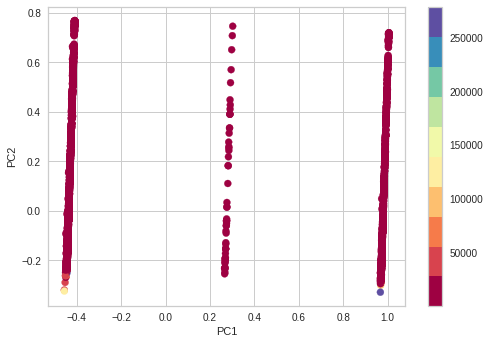

In [ ]:
plt.scatter( transformed[:, 0], transformed[:, 1], c=y, cmap=plt.cm.get_cmap('Spectral', 10) )
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
# PCA with 5 features

pca = PCA(n_components=2)
transformed = pca.fit_transform(X_5f)
transformed.shape

(4330, 2)

Text(0, 0.5, 'PC2')

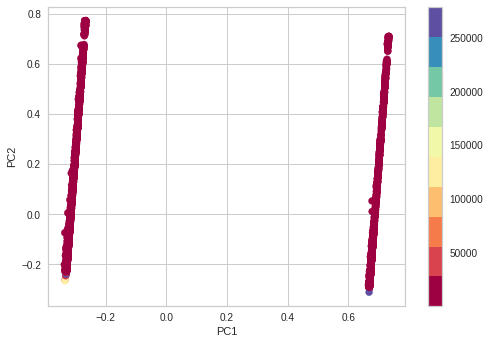

In [ ]:
plt.scatter( transformed[:, 0], transformed[:, 1], c=y, cmap=plt.cm.get_cmap('Spectral', 10) )
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
# PCA with 3 features

pca = PCA(n_components=2)
transformed = pca.fit_transform(X_3f)
transformed.shape

(4330, 2)

Text(0, 0.5, 'PC2')

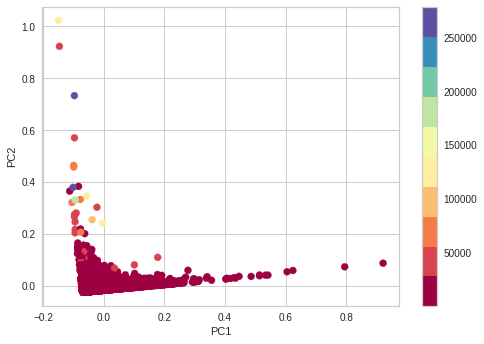

In [ ]:
plt.scatter( transformed[:, 0], transformed[:, 1], c=y, cmap=plt.cm.get_cmap('Spectral', 10) )
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')

Usando o UMAP para visualizar os dados clusterizados

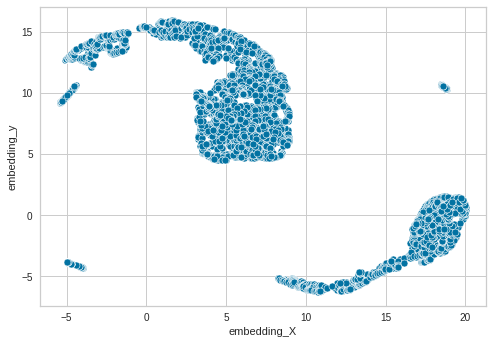

In [ ]:
# Usando o UMAP com TODAS as features
reducer = umap.UMAP(random_state = 0)
embedding = reducer.fit_transform(X_min_max) #gera o espaço projetado - embedding é a projeção gerada em outro espaço

#embedding
df_umap = pd.DataFrame()
df_umap['embedding_X'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

#plot UMAP - cluster projetado de alta dimencionalidade
sns.scatterplot(x = 'embedding_X', y = 'embedding_y', data = df_umap);

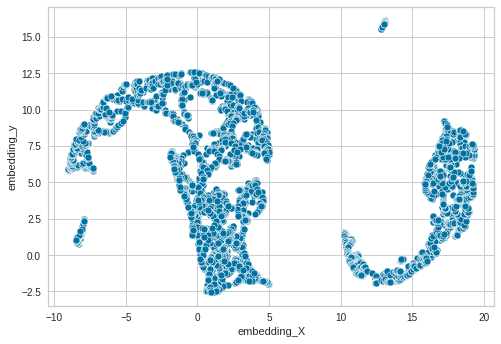

In [ ]:
# Usando o UMAP com 5 features
reducer = umap.UMAP(random_state = 0)
embedding = reducer.fit_transform(X_5f) #gera o espaço projetado - embedding é a projeção gerada em outro espaço

#embedding
df_umap = pd.DataFrame()
df_umap['embedding_X'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

#plot UMAP - cluster projetado de alta dimencionalidade
sns.scatterplot(x = 'embedding_X', y = 'embedding_y', data = df_umap);

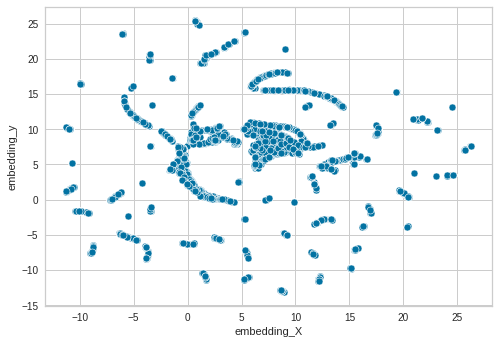

In [ ]:
# Usando o UMAP com 3 features
reducer = umap.UMAP(random_state = 0)
embedding = reducer.fit_transform(X_3f) #gera o espaço projetado - embedding é a projeção gerada em outro espaço

#embedding
df_umap = pd.DataFrame()
df_umap['embedding_X'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

#plot UMAP - cluster projetado de alta dimencionalidade
sns.scatterplot(x = 'embedding_X', y = 'embedding_y', data = df_umap);

Usando o t-SNE para visualizar os dados clusterizados

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


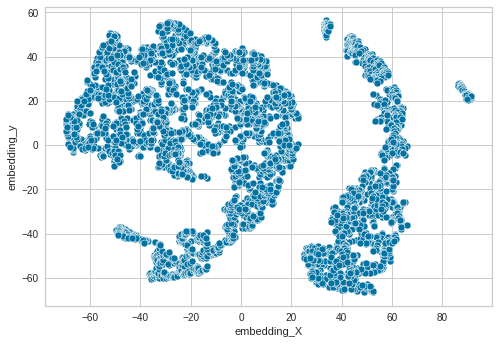

In [ ]:
# Usando o t-SNE com TODAS as variáveis

reducer = TSNE( n_components = 2, n_jobs = -1, random_state = 0)
embedding = reducer.fit_transform(X_min_max) #gera o espaço projetado - embedding é a projeção gerada em outro espaço

#embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_X'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

#plot UMAP - cluster projetado de alta dimencionalidade
sns.scatterplot(x = 'embedding_X', y = 'embedding_y',data = df_tsne);

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


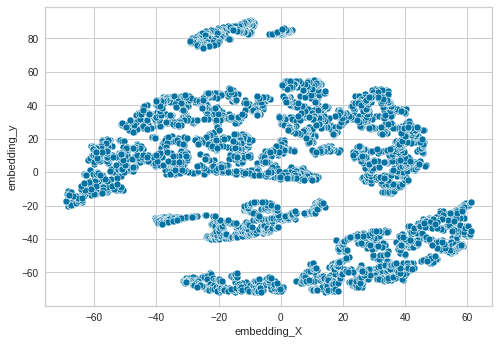

In [ ]:
# Usando o t-SNE com 5 variáveis

reducer = TSNE( n_components = 2, n_jobs = -1, random_state = 0)
embedding = reducer.fit_transform(X_5f) #gera o espaço projetado - embedding é a projeção gerada em outro espaço

#embedding
df_tsne_5f = pd.DataFrame()
df_tsne_5f['embedding_X'] = embedding[:, 0]
df_tsne_5f['embedding_y'] = embedding[:, 1]

#plot UMAP - cluster projetado de alta dimencionalidade
sns.scatterplot(x = 'embedding_X', y = 'embedding_y',data = df_tsne_5f);

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


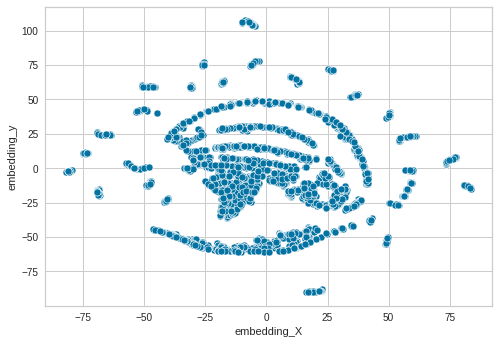

In [ ]:
# Usando o t-SNE com 3 variáveis

reducer = TSNE( n_components = 2, n_jobs = -1, random_state = 0)
embedding = reducer.fit_transform(X_3f) #gera o espaço projetado - embedding é a projeção gerada em outro espaço

#embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_X'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

#plot UMAP - cluster projetado de alta dimencionalidade
sns.scatterplot(x = 'embedding_X', y = 'embedding_y',data = df_tsne);

## Machine Learning

#### K-Means

In [ ]:
clusters = np.arange(2, 31, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [ ]:
# Using the dataframe df_tsne_5f
wcss = []

for i in clusters:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df_tsne_5f)
    print( i , kmeans.inertia_ )
    wcss.append(kmeans.inertia_ )

2 5926524.0
3 3993388.0
4 2940657.0
5 2098922.5
6 1768683.75
7 1431601.75
8 1168531.5
9 964864.375
10 799217.75
11 710996.125
12 639494.75
13 573522.5625
14 518133.8125
15 464857.65625
16 430776.6875
17 402013.0
18 369182.9375
19 344687.25
20 320994.1875
21 304261.0
22 287113.0625
23 271945.3125
24 253713.03125
25 246435.9375
26 232385.125
27 218852.09375
28 215870.28125
29 203365.125
30 196047.546875


Text(0, 0.5, 'WSS')

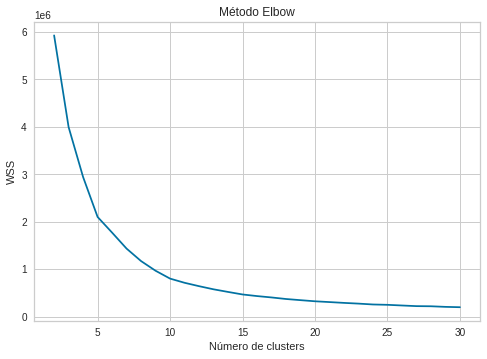

In [ ]:
plt.plot( clusters, wcss )
plt.title("Método Elbow")
plt.xlabel('Número de clusters')
plt.ylabel('WSS')

##### GMM

In [ ]:
gmm_sil = []
for k in clusters:
    gmm_model = mx.GaussianMixture(n_components = k, n_init = 100, random_state = 42)
    gmm_model.fit(df_tsne_5f)
    
    labels = gmm_model.predict(df_tsne_5f)
    
    sil = silhouette_score(df_tsne_5f, labels, metric = 'euclidean')
    gmm_sil.append(sil)

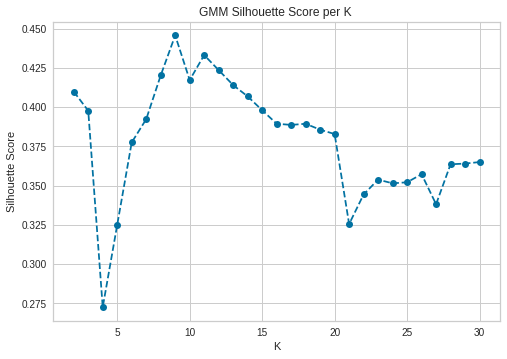

In [ ]:
# GMM Silhouette Score
plt.plot(clusters, gmm_sil, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel( 'K' );
plt.ylabel('Silhouette Score');
plt.title('GMM Silhouette Score per K ');

##### Silhouette

In [ ]:
sill_scores = []

for i in clusters:
    kmeans_model = KMeans( n_clusters = i, n_init = 100, random_state =0)
    kmeans_model.fit(df_tsne_5f)
    labels = kmeans_model.predict(df_tsne_5f)
    sil = silhouette_score( df_tsne_5f, labels, metric = 'euclidean')
    sill_scores.append(sil)  

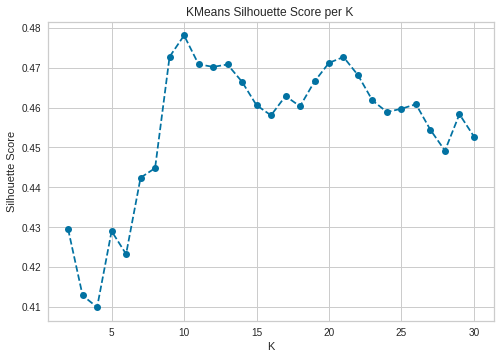

In [ ]:
plt.plot( clusters, sill_scores, linestyle = '--', marker = 'o', color = 'b' )
plt.xlabel( 'K' );
plt.ylabel('Silhouette Score');
plt.title('KMeans Silhouette Score per K ');

For K = 2. Silhouette Score: 0.4287763237953186
For K = 3. Silhouette Score: 0.3954717218875885
For K = 4. Silhouette Score: 0.3920576572418213
For K = 5. Silhouette Score: 0.43471479415893555
For K = 6. Silhouette Score: 0.41014301776885986
For K = 7. Silhouette Score: 0.3961482048034668
For K = 8. Silhouette Score: 0.4086381196975708
For K = 9. Silhouette Score: 0.4082909822463989
For K = 10. Silhouette Score: 0.4233410954475403
For K = 11. Silhouette Score: 0.4389720559120178
For K = 12. Silhouette Score: 0.45378679037094116
For K = 13. Silhouette Score: 0.45114123821258545
For K = 14. Silhouette Score: 0.45055049657821655
For K = 15. Silhouette Score: 0.44941002130508423
For K = 16. Silhouette Score: 0.44040530920028687
For K = 17. Silhouette Score: 0.44152066111564636
For K = 18. Silhouette Score: 0.4424906075000763
For K = 19. Silhouette Score: 0.43882685899734497
For K = 20. Silhouette Score: 0.43613871932029724
For K = 21. Silhouette Score: 0.4417494535446167
For K = 22. Silhou

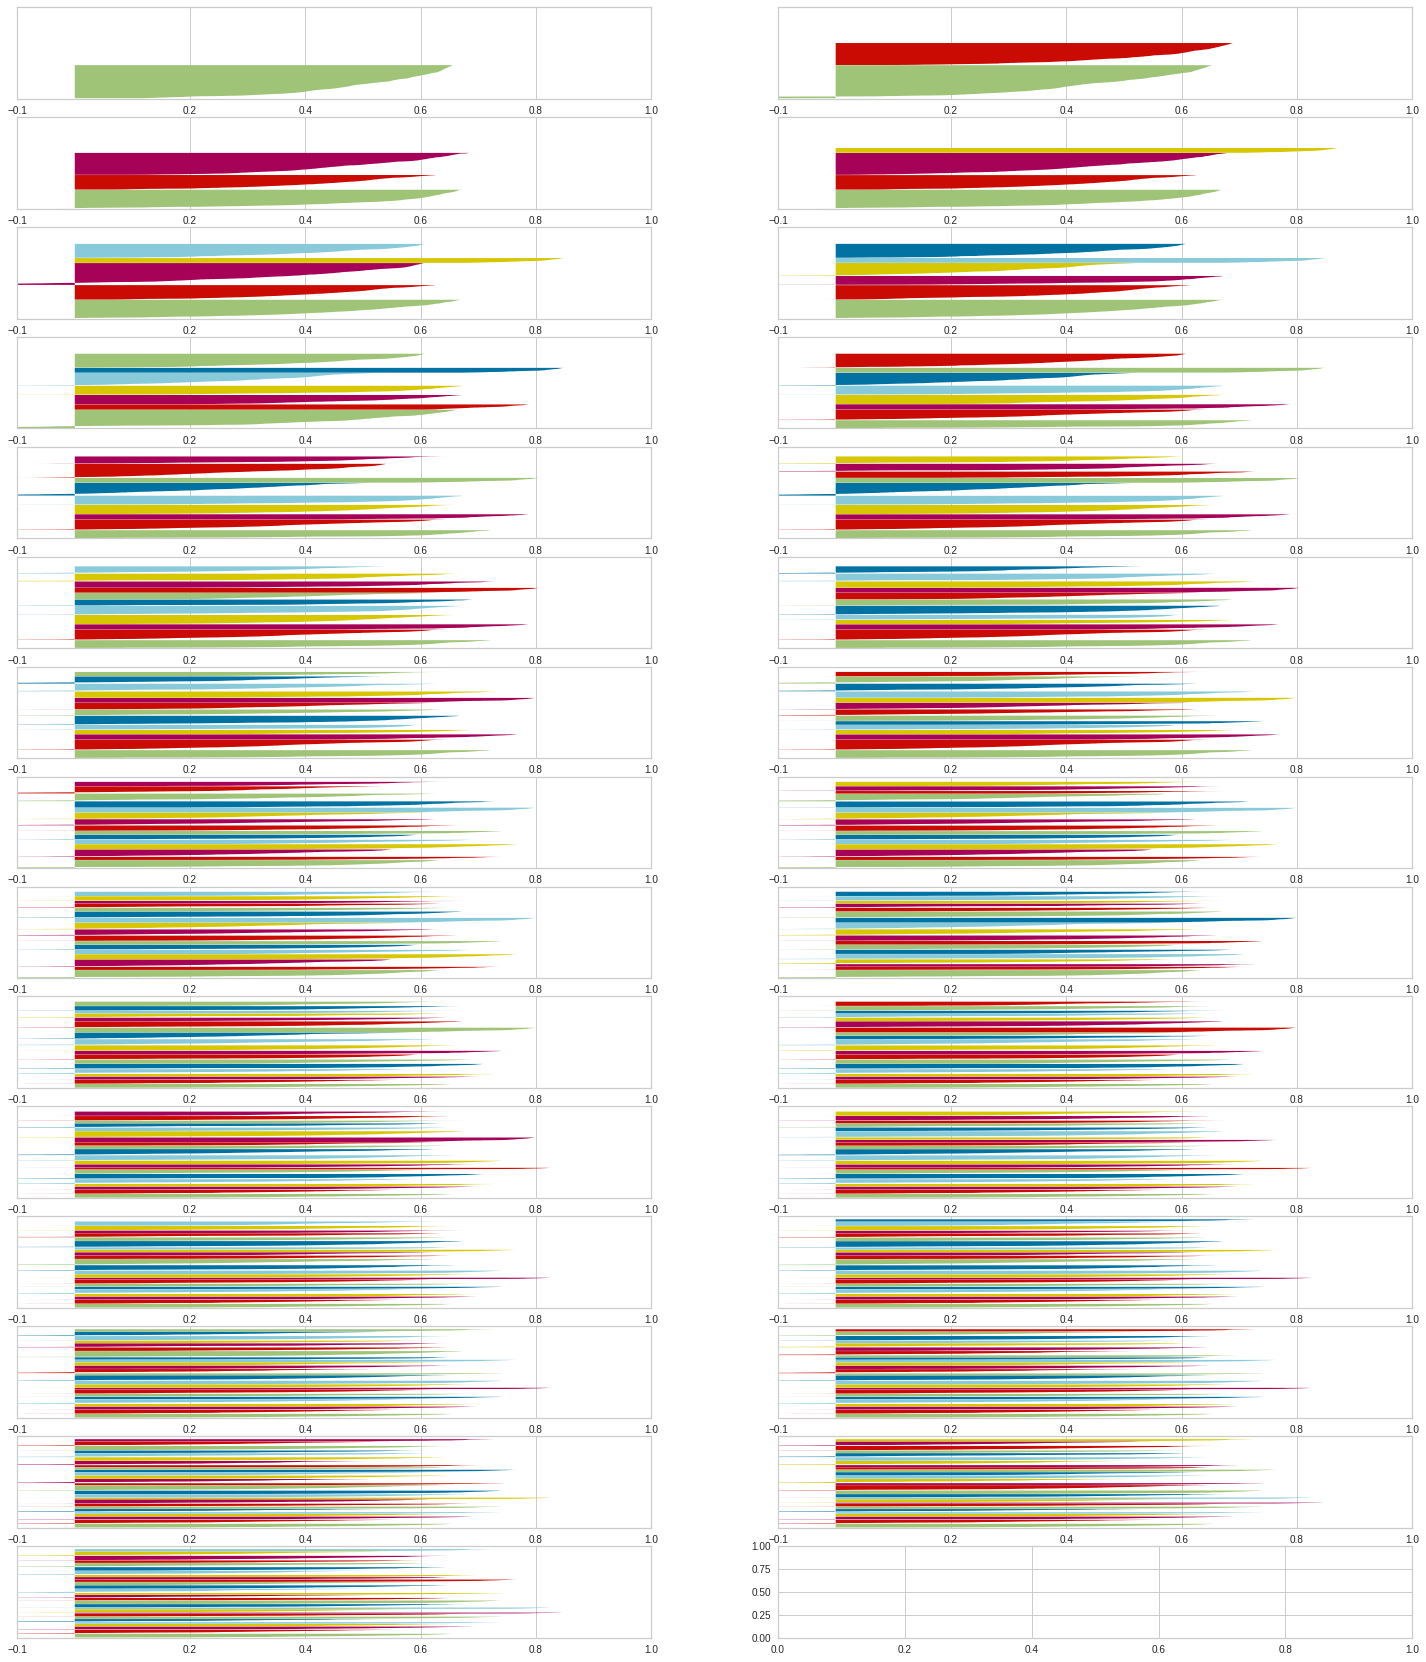

In [ ]:
fig, ax = plt.subplots(15, 2)
fig.set_size_inches(25,30)

for k in clusters:
    q, mod = divmod(k, 2)
    
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(df_tsne_5f) + (k+1)*10])
    
    # model definition and training
    hc_model = hc.linkage(df_tsne_5f, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion = 'maxclust')

    # model performance
    ss = silhouette_score(df_tsne_5f, labels, metric = 'euclidean')
    print('For K = {}. Silhouette Score: {}'.format(k, ss))
    
    samples_silhouette_values = silhouette_samples(df_tsne_5f, labels)
    
    y_lower = 10
    
    for i in range(k):
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)
        
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0.2, 0.4, 0.6, 0.8, 1])

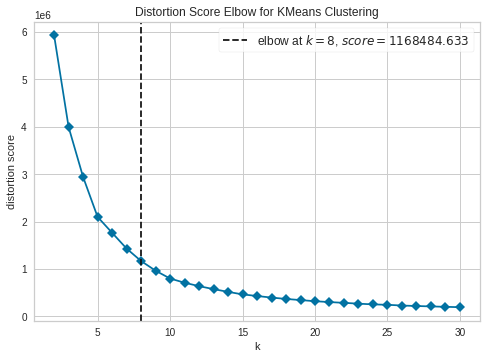

In [ ]:
# Whitin-Cluster Sum of Square (WSS)
kmeans = KElbowVisualizer(KMeans(), k = clusters, timings = False)
kmeans.fit(df_tsne_5f)
kmeans.show();

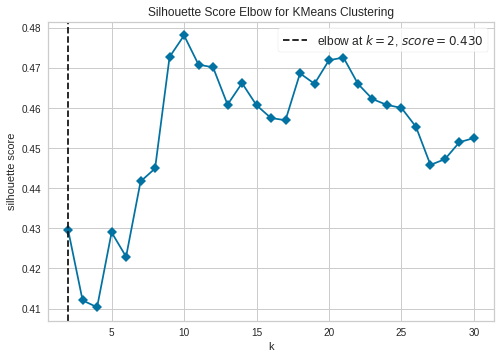

In [ ]:
# Sillhouette Score
kmeans = KElbowVisualizer(KMeans(), k = clusters, metric = 'silhouette', timings = False)
kmeans.fit(df_tsne_5f)
kmeans.show();

##### Silhouette Análise

IndexError: ignored

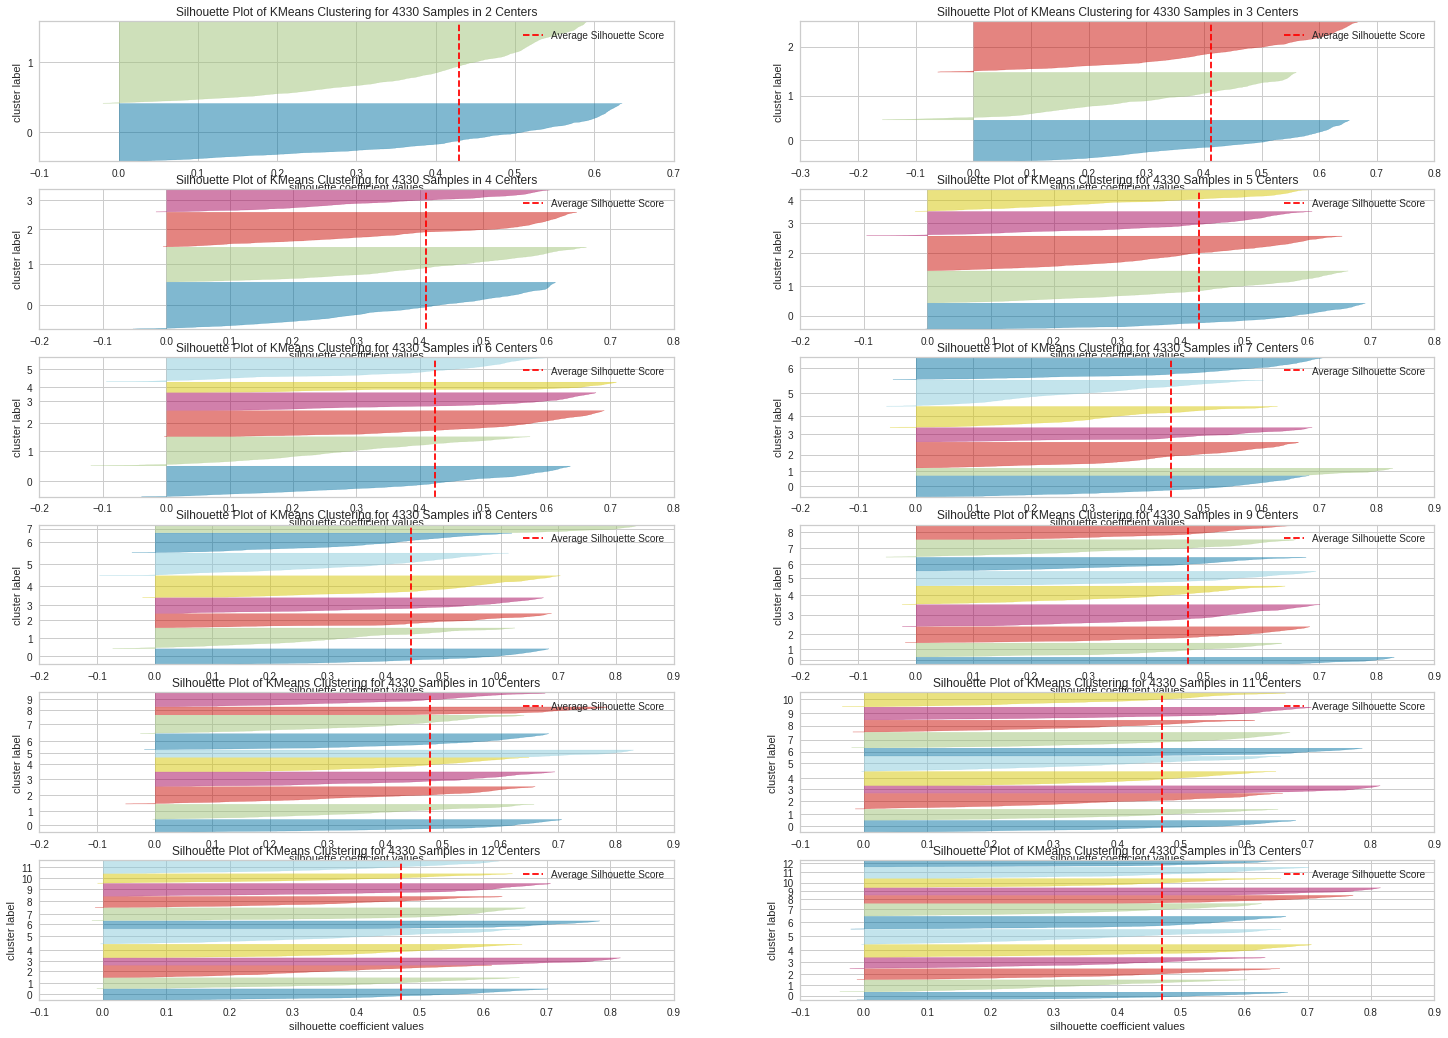

In [ ]:
fig, ax = plt.subplots(6, 2, figsize = (25, 18))

for k  in clusters:
    km = KMeans(n_clusters = k, init = 'random', n_init = 100, max_iter = 100, random_state = 42)
    #truque: divisão com moda (para visualizacao)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(df_tsne_5f)
    visualizer.finalize();

In [ ]:
# choosing number of cluster
k = 9

In [ ]:
# Choosing KNN as model
# model definition
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 100, max_iter = 300, random_state = 42)

# model training
kmeans.fit(df_tsne_5f)

# clustering
labels = kmeans.labels_

In [ ]:
# Chooding GMM as model
# model definition
gmm_model = mx.GaussianMixture(n_components = k,n_init = 50, max_iter = 300 ,random_state=42)

# model training
gmm_model.fit(df_tsne_5f)

# model prediction
labels = gmm_model.predict(df_tsne_5f)

In [ ]:
# Model validation

print('WSS score: {}'.format(kmeans.inertia_))

WSS score: 964820.5


In [ ]:
df_semi_final = df_tsne_5f.copy()
df_semi_final['cluster'] = labels
df_semi_final.head()

,embedding_X,embedding_y,cluster
0,3.586728,84.986748,0
1,9.614042,44.976742,4
2,-61.476986,-5.775456,2
3,9.576889,-69.793816,1
4,-9.559308,90.709404,0


In [ ]:
df_semi_final.shape

(4330, 3)

#### Inspeção Visual

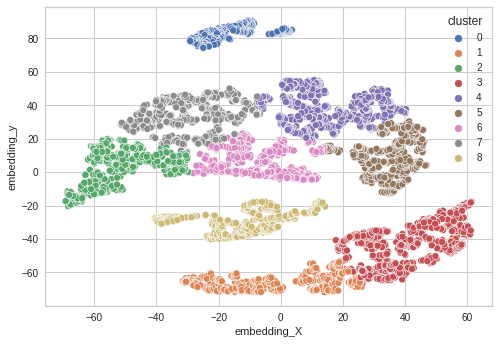

In [ ]:
# # modelo escolhido

# k = 9 for K-means

sns.scatterplot(x = 'embedding_X', y = 'embedding_y', hue = 'cluster', data = df_semi_final, palette = 'deep');

In [ ]:
# k = 7 for K-means

sns.scatterplot(x = 'embedding_X', y = 'embedding_y', hue = 'cluster', data = df_semi_final, palette = 'deep');

In [ ]:
# k = 8 for K-means

sns.scatterplot(x = 'embedding_X', y = 'embedding_y', hue = 'cluster', data = df_semi_final, palette = 'deep');

In [ ]:
# k = 9 for GMM

sns.scatterplot(x = 'embedding_X', y = 'embedding_y', hue = 'cluster', data = df_semi_final, palette = 'deep');

In [ ]:
# k = 7 for GMM

sns.scatterplot(x = 'embedding_X', y = 'embedding_y', hue = 'cluster', data = df_semi_final, palette = 'deep');

In [ ]:
# k = 8 for GMM

sns.scatterplot(x = 'embedding_X', y = 'embedding_y', hue = 'cluster', data = df_semi_final, palette = 'deep');

In [ ]:
# k = 10 for GMM

sns.scatterplot(x = 'embedding_X', y = 'embedding_y', hue = 'cluster', data = df_semi_final, palette = 'deep');

O modelo de clusterização a ser escolhido será o de KNN com o k = 9

### Adicionando o Cluster no dataset

In [ ]:
df_aux_final = df_clusters.copy()
df_aux_final

,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,Avg_basket_size,Avg_products_per_basket,Avg_ticket,afternoon,morning
0,5322.84,34,1703,21,371,50.088235,0.617647,156.554118,0.0,1.0
1,3105.70,9,1361,105,56,151.222222,11.666667,345.077778,1.0,0.0
2,6690.18,15,5014,114,2,334.266667,7.600000,446.012000,1.0,0.0
3,948.25,5,439,24,95,87.800000,4.800000,189.650000,0.0,1.0
4,843.15,3,77,1,333,25.666667,0.333333,281.050000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
4325,196.89,1,76,12,1,76.000000,12.000000,196.890000,0.0,1.0
4326,343.50,1,314,18,1,314.000000,18.000000,343.500000,0.0,1.0
4327,360.00,1,96,2,0,96.000000,2.000000,360.000000,1.0,0.0
4328,227.39,1,79,10,0,79.000000,10.000000,227.390000,1.0,0.0


In [ ]:
df_aux_final['CustomerID'] = df_clientes_ref['CustomerID']
df_aux_final.head()

,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,Avg_basket_size,Avg_products_per_basket,Avg_ticket,afternoon,morning,CustomerID
0,5322.84,34,1703,21,371,50.088235,0.617647,156.554118,0.0,1.0,17850.0
1,3105.70,9,1361,105,56,151.222222,11.666667,345.077778,1.0,0.0,13047.0
2,6690.18,15,5014,114,2,334.266667,7.600000,446.012000,1.0,0.0,12583.0
3,948.25,5,439,24,95,87.800000,4.800000,189.650000,0.0,1.0,13748.0
4,843.15,3,77,1,333,25.666667,0.333333,281.050000,0.0,1.0,15100.0


In [ ]:
df_aux_final['cluster'] = labels
df_aux_final.head()

,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,Avg_basket_size,Avg_products_per_basket,Avg_ticket,afternoon,morning,CustomerID,cluster
0,5322.84,34,1703,21,371,50.088235,0.617647,156.554118,0.0,1.0,17850.0,0
1,3105.70,9,1361,105,56,151.222222,11.666667,345.077778,1.0,0.0,13047.0,4
2,6690.18,15,5014,114,2,334.266667,7.600000,446.012000,1.0,0.0,12583.0,2
3,948.25,5,439,24,95,87.800000,4.800000,189.650000,0.0,1.0,13748.0,1
4,843.15,3,77,1,333,25.666667,0.333333,281.050000,0.0,1.0,15100.0,0


In [ ]:
df_No_of_clients = df_aux_final[['cluster','CustomerID']].groupby('cluster').count()
df_No_of_clients

,CustomerID
cluster,
0,231
1,438
2,507
3,691
4,579
5,460
6,430
7,549
8,445


In [ ]:
df_final = df_aux_final.groupby('cluster').mean().sort_values(by='Total_Revenue', ascending=False).reset_index()
df_final = pd.merge(df_final, df_No_of_clients, how='left', on='cluster' )

In [ ]:
df_final.rename(columns={'CustomerID': 'Number_of_clients'}, inplace=True)

In [ ]:
df_final

,cluster,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,Avg_basket_size,Avg_products_per_basket,Avg_ticket,afternoon,morning,Number_of_clients
0,2,5585.944122,12.067061,3132.410256,114.844181,5.074951,212.702399,11.531103,369.823986,1.0,0.000000,507
1,3,3357.554645,5.170767,2028.908828,66.635311,24.015919,263.986039,17.289561,440.654705,0.0,0.973951,691
2,6,1740.447140,3.223256,1027.965116,134.262791,23.618605,313.056894,46.110513,492.583799,1.0,0.000000,430
3,7,1522.027905,4.845173,934.027322,58.511840,24.561020,180.906802,12.191947,289.730169,1.0,0.000000,549
4,4,1016.436288,2.899827,656.492228,42.782383,65.953368,237.087186,16.265365,353.245113,1.0,0.000000,579
5,1,791.093836,2.189498,480.490868,29.536530,124.271689,228.462271,14.717761,366.345225,0.0,0.945205,438
6,5,705.016130,2.232609,457.284783,40.117391,146.713043,208.193976,19.835666,328.200554,1.0,0.000000,460
7,8,494.693393,1.370787,261.534831,24.595506,283.217978,190.445362,19.343958,347.866014,1.0,0.000000,445
8,0,400.909264,1.385281,229.090909,17.255411,296.935065,173.303412,14.539470,312.207330,0.0,0.952381,231


In [ ]:
df_incomes = df_aux_final[['cluster','Total_Revenue']].groupby('cluster').sum().reset_index()
df_incomes

,cluster,Total_Revenue
0,0,92610.040
1,1,346499.100
2,2,2832073.670
3,3,2320070.260
4,4,588516.611
5,5,324307.420
6,6,748392.270
7,7,835593.320
8,8,220138.560


In [ ]:
clusters_name = ['cluster_0','cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8']
df_incomes['cluster'] = clusters_name
df_incomes

,cluster,Total_Revenue
0,cluster_0,92610.040
1,cluster_1,346499.100
2,cluster_2,2832073.670
3,cluster_3,2320070.260
4,cluster_4,588516.611
5,cluster_5,324307.420
6,cluster_6,748392.270
7,cluster_7,835593.320
8,cluster_8,220138.560


In [ ]:
df_incomes = df_incomes.sort_values(by='Total_Revenue', ascending=False)

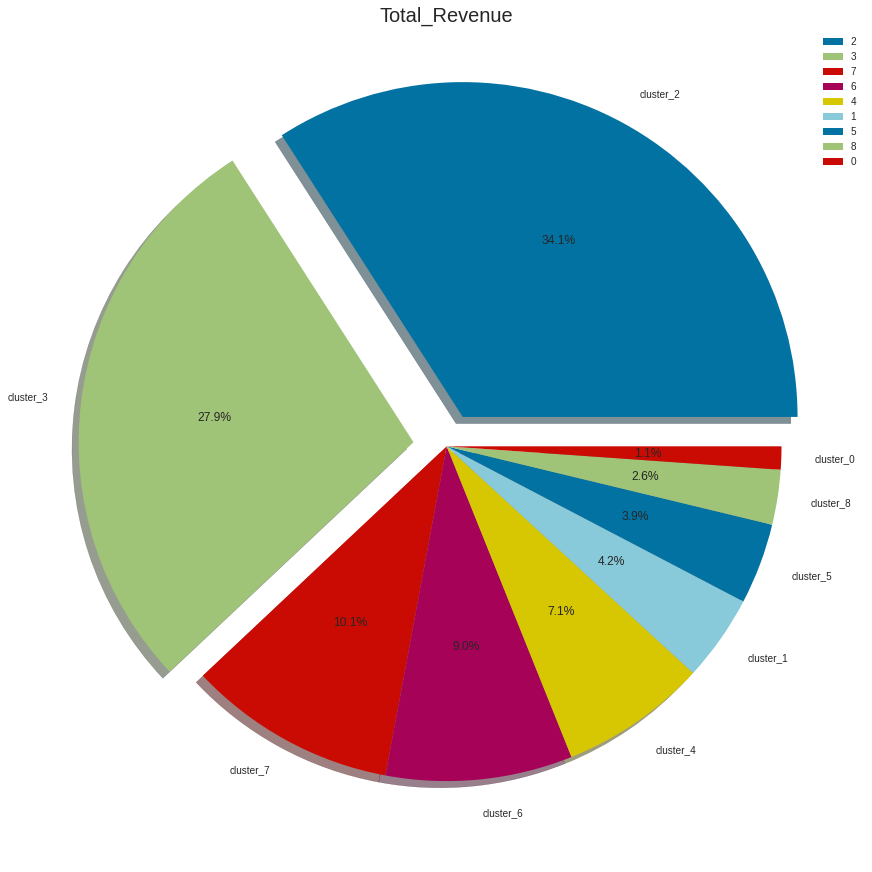

In [ ]:
explode = [0.1,0.1,0,0,0,0,0,0,0]

plt.figure(figsize=(15,20))
plt.pie(df_incomes['Total_Revenue'], labels=df_incomes['cluster'], explode=explode, autopct='%1.1f%%', shadow=True)
plt.title('Total_Revenue',fontsize=20)
plt.legend(df_incomes.index)
plt.show()

In [ ]:
df_transaction = df_aux_final[['cluster','Total_Transactions']].groupby('cluster').sum().reset_index()
df_transaction

,cluster,Total_Transactions
0,0,320
1,1,959
2,2,6118
3,3,3573
4,4,1679
5,5,1027
6,6,1386
7,7,2660
8,8,610


In [ ]:
df_transaction['cluster'] = clusters_name
df_transaction = df_transaction.sort_values(by='Total_Transactions', ascending= False)
df_transaction

,cluster,Total_Transactions
2,cluster_2,6118
3,cluster_3,3573
7,cluster_7,2660
4,cluster_4,1679
6,cluster_6,1386
5,cluster_5,1027
1,cluster_1,959
8,cluster_8,610
0,cluster_0,320


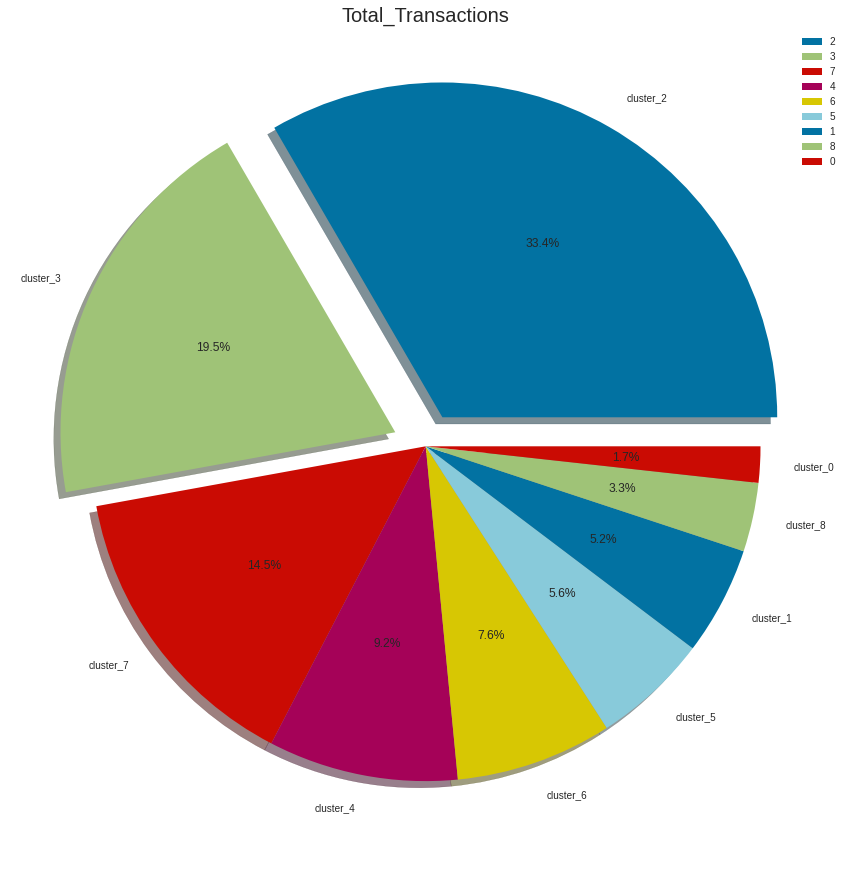

In [ ]:
explode = [0.1,0.1,0,0,0,0,0,0,0]

plt.figure(figsize=(15,20))
plt.pie(df_transaction['Total_Transactions'], labels=df_transaction['cluster'], explode=explode, autopct='%1.1f%%', shadow=True)
plt.title('Total_Transactions',fontsize=20)
plt.legend(df_transaction.index)
plt.show()

In [ ]:
df_quantities = df_aux_final[['cluster','Total_Quantity']].groupby('cluster').sum().reset_index()
df_quantities

,cluster,Total_Quantity
0,0,52920
1,1,210455
2,2,1588132
3,3,1401976
4,4,380109
5,5,210351
6,6,442025
7,7,512781
8,8,116383


In [ ]:
df_quantities['cluster'] = clusters_name
df_quantities = df_quantities.sort_values(by='Total_Quantity', ascending= False)
df_quantities

,cluster,Total_Quantity
2,cluster_2,1588132
3,cluster_3,1401976
7,cluster_7,512781
6,cluster_6,442025
4,cluster_4,380109
1,cluster_1,210455
5,cluster_5,210351
8,cluster_8,116383
0,cluster_0,52920


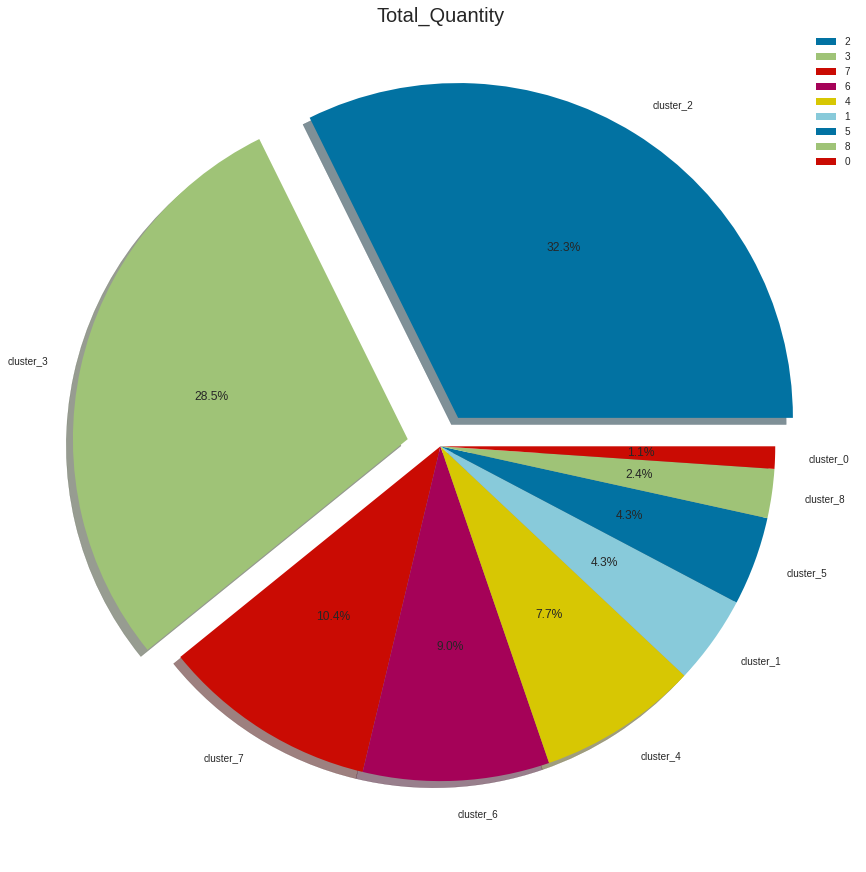

In [ ]:
explode = [0.1,0.1,0,0,0,0,0,0,0]

plt.figure(figsize=(15,20))
plt.pie(df_quantities['Total_Quantity'], labels=df_quantities['cluster'], explode=explode, autopct='%1.1f%%', shadow=True)
plt.title('Total_Quantity',fontsize=20)
plt.legend(df_quantities.index)
plt.show()

In [ ]:
df_aux_final

,Total_Revenue,Total_Transactions,Total_Quantity,Total_Products,Recency_in_days,Avg_basket_size,Avg_products_per_basket,Avg_ticket,afternoon,morning,CustomerID,cluster
0,5322.84,34,1703,21,371,50.088235,0.617647,156.554118,0.0,1.0,17850.0,0
1,3105.70,9,1361,105,56,151.222222,11.666667,345.077778,1.0,0.0,13047.0,4
2,6690.18,15,5014,114,2,334.266667,7.600000,446.012000,1.0,0.0,12583.0,2
3,948.25,5,439,24,95,87.800000,4.800000,189.650000,0.0,1.0,13748.0,1
4,843.15,3,77,1,333,25.666667,0.333333,281.050000,0.0,1.0,15100.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4325,196.89,1,76,12,1,76.000000,12.000000,196.890000,0.0,1.0,13436.0,3
4326,343.50,1,314,18,1,314.000000,18.000000,343.500000,0.0,1.0,15520.0,3
4327,360.00,1,96,2,0,96.000000,2.000000,360.000000,1.0,0.0,13298.0,2
4328,227.39,1,79,10,0,79.000000,10.000000,227.390000,1.0,0.0,14569.0,2


### Respostas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
2. Quantos clientes farão parte do grupo?
3. Quais as principais características desses clientes ?
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
7. Quais as condições para uma pessoa ser removida do Insiders ?
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

1) Os clientes classificados no cluster n° 3

2) 378 clientes (8,73% dos clientes)

3) Os clientes insiders possuem características como um grande volume de transações (> 5000), grande número total de produtos (> 120), baixa recência (< 6 dias) e realizam transações majoritariamente no período da tarde.

4) Os clientes insiders são responsáveis por 30,7% de toda a receita da loja.

5) A expectativa é que cada um desses clientes insiders possam contribuir com uma receita de R$ 7.123,13

6) Para ser considerado um cliente insider é necessário que o cliente seja classificado no cluster 3 após a aplicação do modelo de segmentação de clientes presente neste notebook.

7) As condições para que uma pessoa seja removida da condição de insiders é que a mesma seja classificada em clusters que não seja o cluster n° 3 ou o cluster n° 6. Se o cliente vier a ser classificado no cluster n°6 por um determinado período, não existe a necessidade de retitá-lo do programa insiders, pois os clientes desses dois clusters compartilham de características semelhantes. Pode-se também colocar um critério em que o clientes deverá ser classificado no cluster n° 3 dentro de um período de, no máximo 3 meses.

8) 

9) Uma das características comum entre os clientes insiders é que a maioria deles realizam compras no período da tarde. Sendo assim, pode ser uma boa estratégia realizar promoções ou propagandas nesse mais frequentemente nesse período.

##### Verificando as características que os clusters tem em comum